In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
import math

In [2]:
df = pd.read_csv('winequality-red.csv', sep = ';')
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.groupby('quality')['quality'].count()

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## V.1 Exploring the green reds
### a) Function for pairplotting features

In [5]:
def make_threshold(value, good_threshold, bad_threshold):
    if (value > good_threshold): return 1
    elif (value < bad_threshold): return 0
    return (float('NaN'))

def plot_scatter_matrix(win_data, good_threshold, bad_threshold, save_plot=False):
    win_data['threshold'] = win_data.apply(lambda row: make_threshold(row['quality'],
                                                                      good_threshold,
                                                                      bad_threshold), 
                                                                      axis = 1)
    shape = [3, 3]
    i = 1
    colors = ListedColormap(['red', 'blue'])
    plt.figure(figsize=(shape[0] * 5, shape[1] * 5))
    for feature in win_data.columns[:3]:
        for feature2 in win_data.columns[:3]:
            ax = plt.subplot(shape[0], shape[1], i)
            plt.scatter(win_data[feature], win_data[feature2], c = win_data['threshold'] ,cmap = colors)
            plt.xlabel(feature)
            plt.ylabel(feature2)
            i += 1
    plt.savefig("plot_performance.png") if save_plot else None
    plt.show()

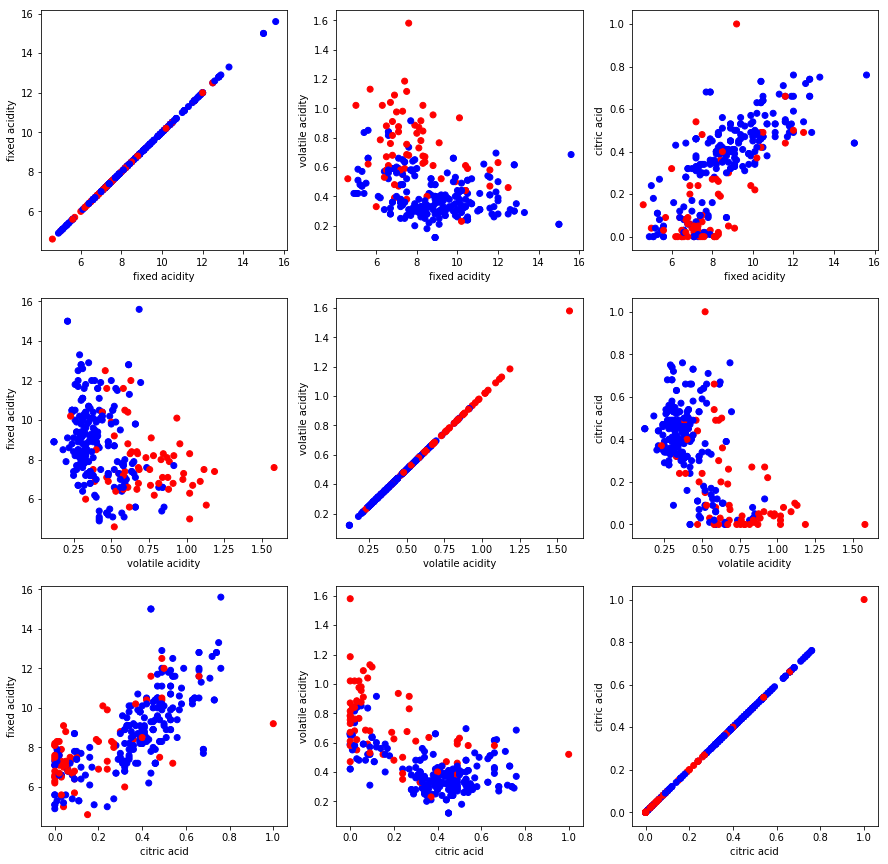

In [6]:
plot_scatter_matrix(df, 6, 5, True)

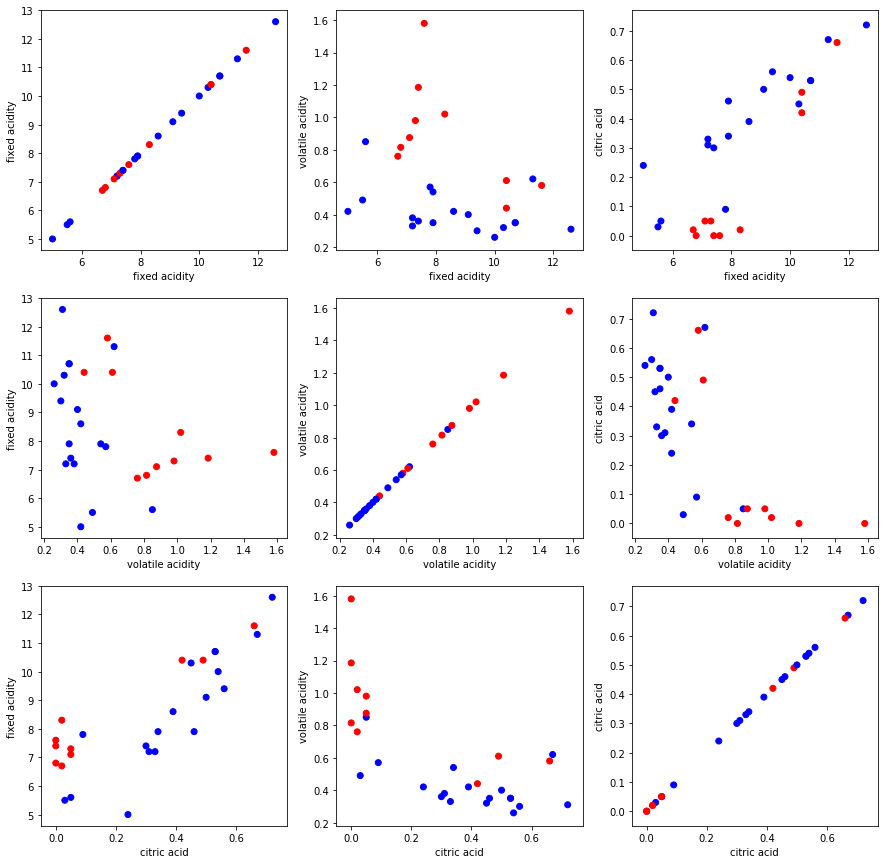

In [7]:
plot_scatter_matrix(df, 7, 4)

### b) Useful qualities to distinguish bad quality wined from good:
*   alcohol
*   citric acid
*   sulphates

These features were chosen because in a graph its easy to see how good wines differ from bad ones

## V.2 Learning to perceptron

#### a) Implement a perceptron

In [8]:
# Activation function (perceptron)
def predict(x, w):
    activation = 0
    for i in range(len(x)):
        activation += w[i] * x[i]
    return 1.0 if activation >= 0 else 0.0

#### b) Function to train a perceptron

In [9]:
def diff(a, b):
    c = list()
    for i, elem in enumerate(a):
        c.append(a[i] - b[i])
    return (c)

def ms_error(x, y, w):
    sum_err = 0
    for i in range(len(y)):
        sum_err += (predict(x[i], w) - y[i])**2
    return sum_err/len(y)

def grad_step(x, y, w, i, l_rate):
    grad = list()
    for j in range(len(x[0])):
        grad.append(x[i][j] * (predict(x[i], w) - y[i]))
    for j in range(len(x[0])):
        grad[j] *= 2 * l_rate / len(x[0])
    return grad

def norm(a, b):
    dist = 0.0;
    for i in range(len(a)):
        dist += (a[i] - b[i]) ** 2
    return (dist ** 0.5)

## TRAIN function
def train_weights(x, y, l_rate, n_epochs):
    w = [random.uniform(0, 1) for i in range(len(x[0]))]
    errors = list()
    weights = list()
    i = 0
    if (n_epochs <= 0):
        while (True):
            w_tmp = list(w)
            random_idx = random.randint(0, len(x) - 1)
            w = diff(w_tmp, grad_step(x, y, w, random_idx, l_rate))
            errors.append(ms_error(x, y, w))
            weights.append(list(w))
            i += 1
            if (norm(w_tmp, w) < 0.01 and i > 50):
                break
    for index in range(n_epochs):
        w_tmp = w
        random_idx = random.randint(0, len(x) - 1)
        w = diff(w_tmp, grad_step(x, y, w, random_idx, l_rate))
        errors.append(ms_error(x, y, w))
        weights.append(list(w))
    
    return [weights, errors]

#### c) Perceptron performance plotting function

In [10]:
def plot_performance(performance, wine_data, good_thresh, bad_thresh, title, features, epoch = -1, save_plot = False):
    wine_data['result'] = wine_data.apply(lambda row: make_threshold(row['quality'], good_thresh, bad_thresh), axis = 1)
    x = wine_data[wine_data.result >= 0][features].values
    y = wine_data[wine_data.result >= 0]['result'].values
    w, errors = performance
    
    shape = [4, 2]
    f = plt.figure(figsize=(shape[0] * 10, shape[1] * 10))
    f.suptitle(title, fontsize=48)
    ax = plt.subplot(shape[1], shape[0], 1)
    ax.set_title('Boundary line')
    plt.xlabel(features[1])
    plt.ylabel(features[2])
    
    x1 = [x1[1] for x1 in x]
    x2 = [x2[2] for x2 in x]
    colors = ListedColormap(['red', 'blue'])
    plt.scatter(x1, x2, c = y, cmap = colors)
    
    def func(x, w):
        slope = -(w[0]/w[2])/(w[0]/w[1])  
        intercept = -w[0]/w[2]
        y = (slope*x) + intercept
        return (y)
    
    x_line = [i for i in range(int(min(x1)) - 2, int(max(x1)) + 2)]
    y_line = [func(i, w[epoch]) for i in x_line]
    plt.plot(x_line, y_line)
    plt.axis([min(x1) - 1, max(x1) + 1, min(x2) - 1, max(x2) + 1])
    
    ax = plt.subplot(shape[1], shape[0], 2)
    ax.set_title('Error / Epoch graph')
    plt.xlabel('epoches')
    plt.ylabel('errors')
    plt.plot(range(len(errors)), errors)
    fig.savefig("plot_performance.png") if save_plot else None

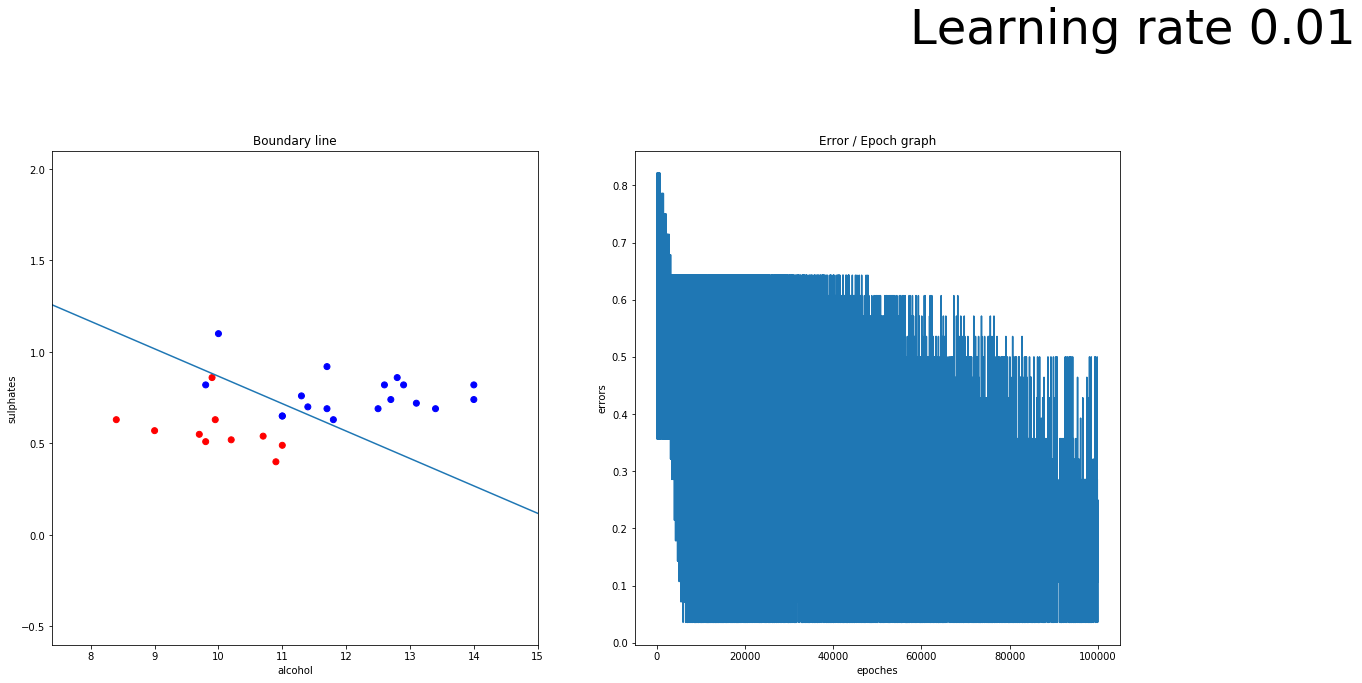

In [11]:
df['result'] = df.apply(lambda row: make_threshold(row['quality'], 7, 4), axis = 1)
df['w0'] = 1
x = df[df.result >= 0][['w0', 'alcohol', 'sulphates']].values
y = df[df.result >= 0]['result'].values
performance = train_weights(x, y, 0.005, 100000)
axes = plot_performance(performance, df, 7, 4, "Learning rate 0.01", ['w0','alcohol', 'sulphates'])

#### d) Feature scaling

In [12]:
def mean(x):
    res = 0.0
    for i in range(len(x)):
        res += x[i]
    return (res / len(x))

def variance(x):
    mu = mean(x)
    res = 0
    for i in range(len(x)):
        res += (x[i] - mu) ** 2
    return (res / len(x))

def std(x):
    return (math.sqrt(variance(x)))

def scale(x, mu, std_):
    return ((x - mu) / std_)

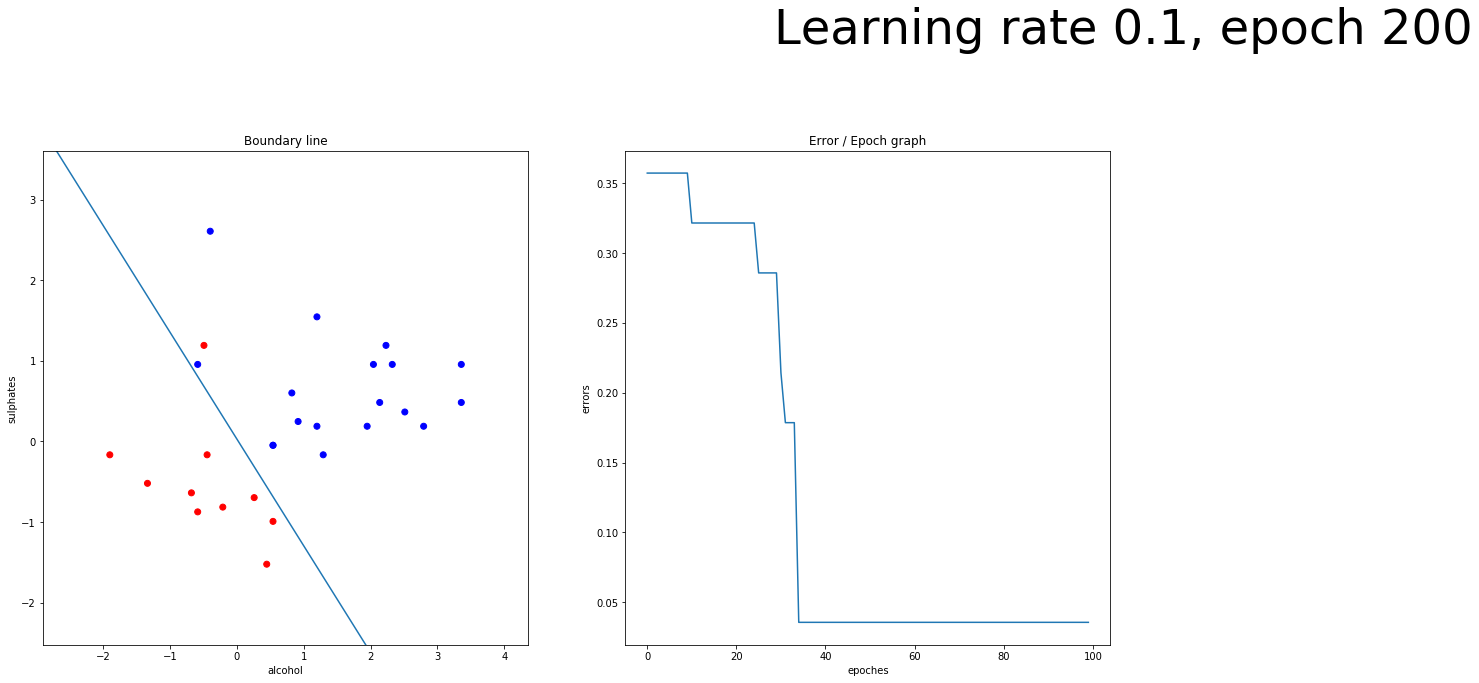

In [13]:
df['result'] = df.apply(lambda row: make_threshold(row['quality'], 7, 4), axis = 1)
df['alcohol'] = df.apply(lambda row: scale(row['alcohol'], mean(df['alcohol'].values), std(df['alcohol'].values)), axis = 1)
df['sulphates'] = df.apply(lambda row: scale(row['sulphates'], mean(df['sulphates'].values), std(df['sulphates'].values)), axis = 1)
x = df[df.result >= 0][['w0', 'alcohol', 'sulphates']].values
y = df[df.result >= 0]['result'].values
performance = train_weights(x, y, 0.1, 100)
plot_performance(performance, df, 7, 4, "Learning rate 0.1, epoch 200", ['w0', 'alcohol', 'sulphates'])

### V.3 My fair ADALINE

#### a) ADALINE Implementation

In [14]:
def adaline_input(x, w):
    res = 0
    for i in range(len(x)):
        res += x[i] * w[i]
    return (res)

def adaline_predict(x, w):
    return 0 if adaline_input(x, w) < 0.0 else 1.0

#### b) function to train ADALINE

In [15]:
def grad_step_ada(x, y, w, i, l_rate):
    grad = list()
    for j in range(len(x[0])):
        if y[i] == adaline_predict(x[i], w):
            grad.append(0)
        else:
            grad.append(x[i][j] * (adaline_input(x[i], w)/len(x[i]) - y[i]))
    for j in range(len(x[0])):
        grad[j] *= 2 * l_rate / len(x[0])
    return grad

def train_adaline(x, y, l_rate, n_epochs):
    w = [random.uniform(0, 1) for i in range(len(x[0]))]
    errors = list()
    weights = list()
    i = 0
    if (n_epochs <= 0):
        while (True):
            w_tmp = list(w)
            random_idx = random.randint(0, len(x) - 1)
            w = diff(w_tmp, grad_step_ada(x, y, w, random_idx, l_rate))
            errors.append(ms_error(x, y, w))
            weights.append(list(w))
            i += 1
            if (norm(w_tmp, w) < 0.01 and i > 500):
                break
    for index in range(n_epochs):
        w_tmp = w
        random_idx = random.randint(0, len(x) - 1)
        w = diff(w_tmp, grad_step_ada(x, y, w, random_idx, l_rate))
        errors.append(ms_error(x, y, w))
        weights.append(list(w))
    
    return [weights, errors]

#### c) Good learning rate

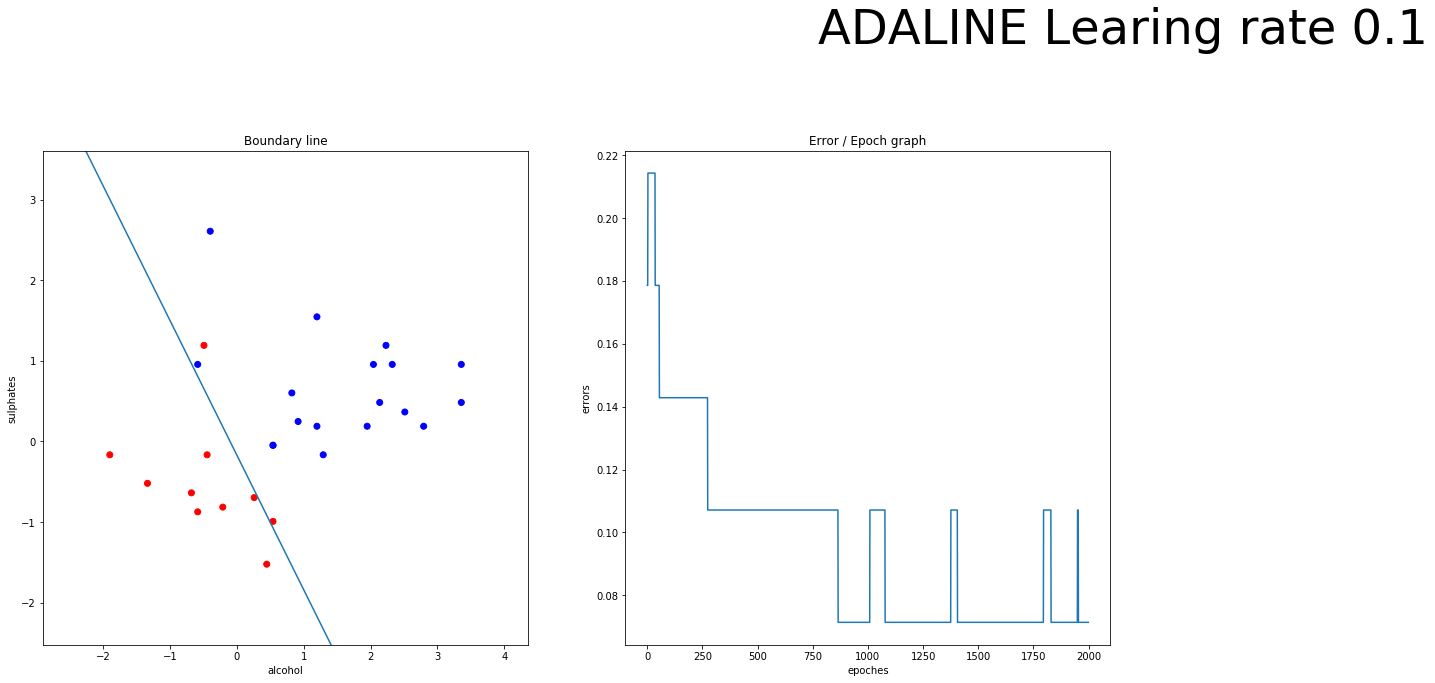

In [16]:
performance = train_adaline(x, y, 0.1, 2000)
plot_performance(performance, df, 7, 4, "ADALINE Learing rate 0.1", ['w0','alcohol', 'sulphates'])

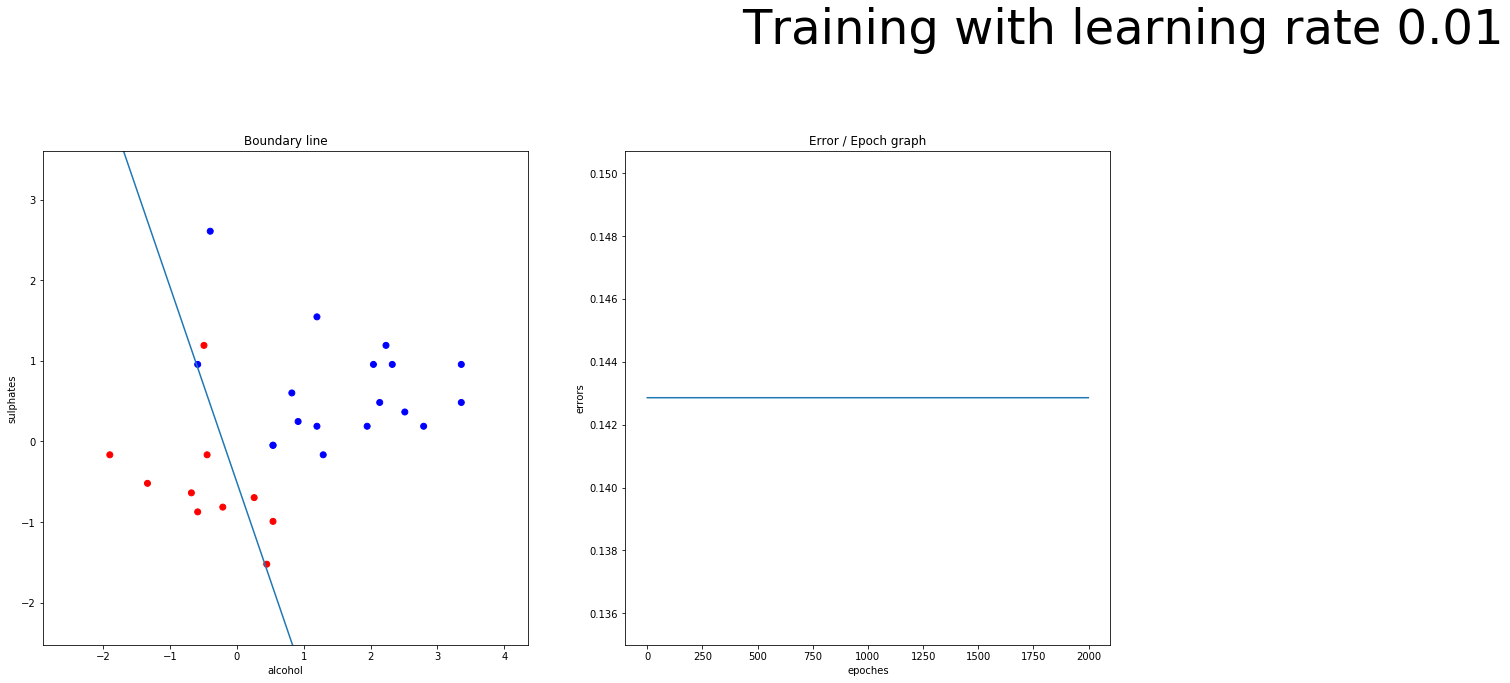

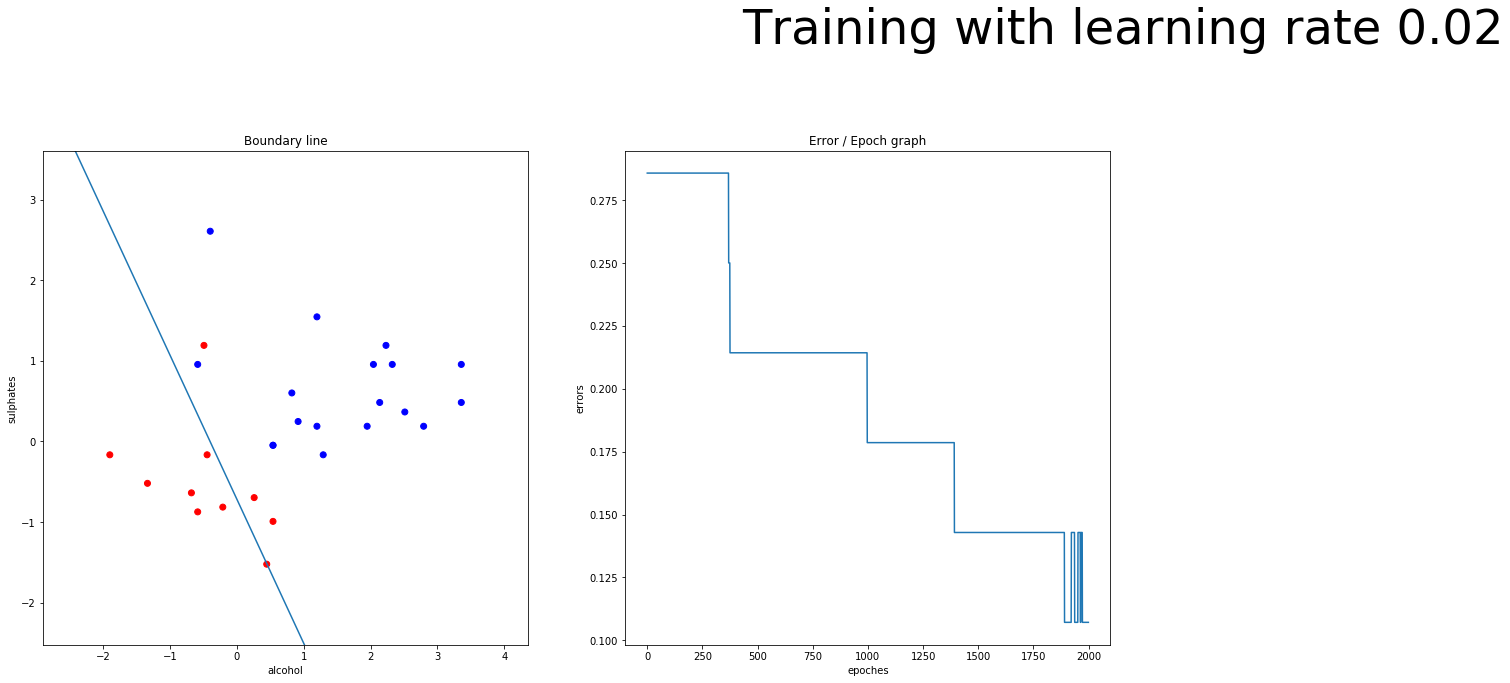

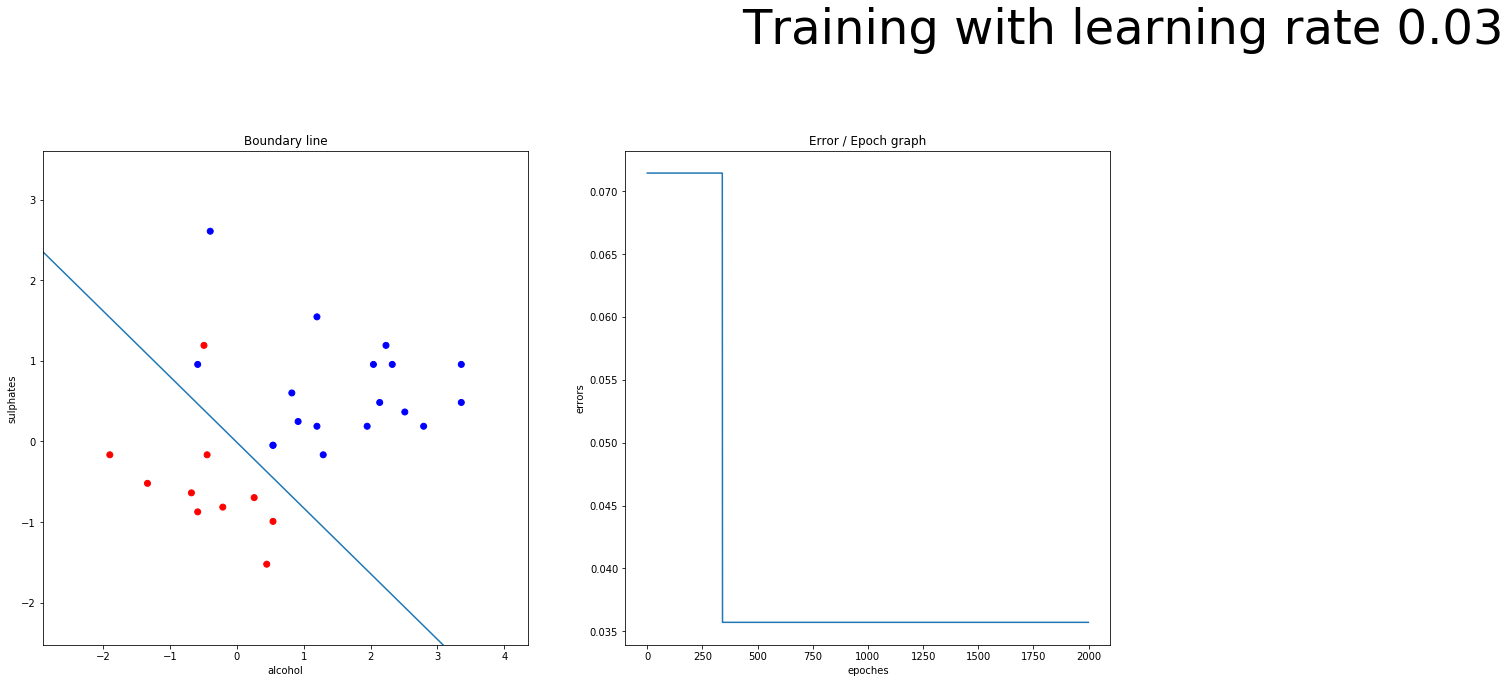

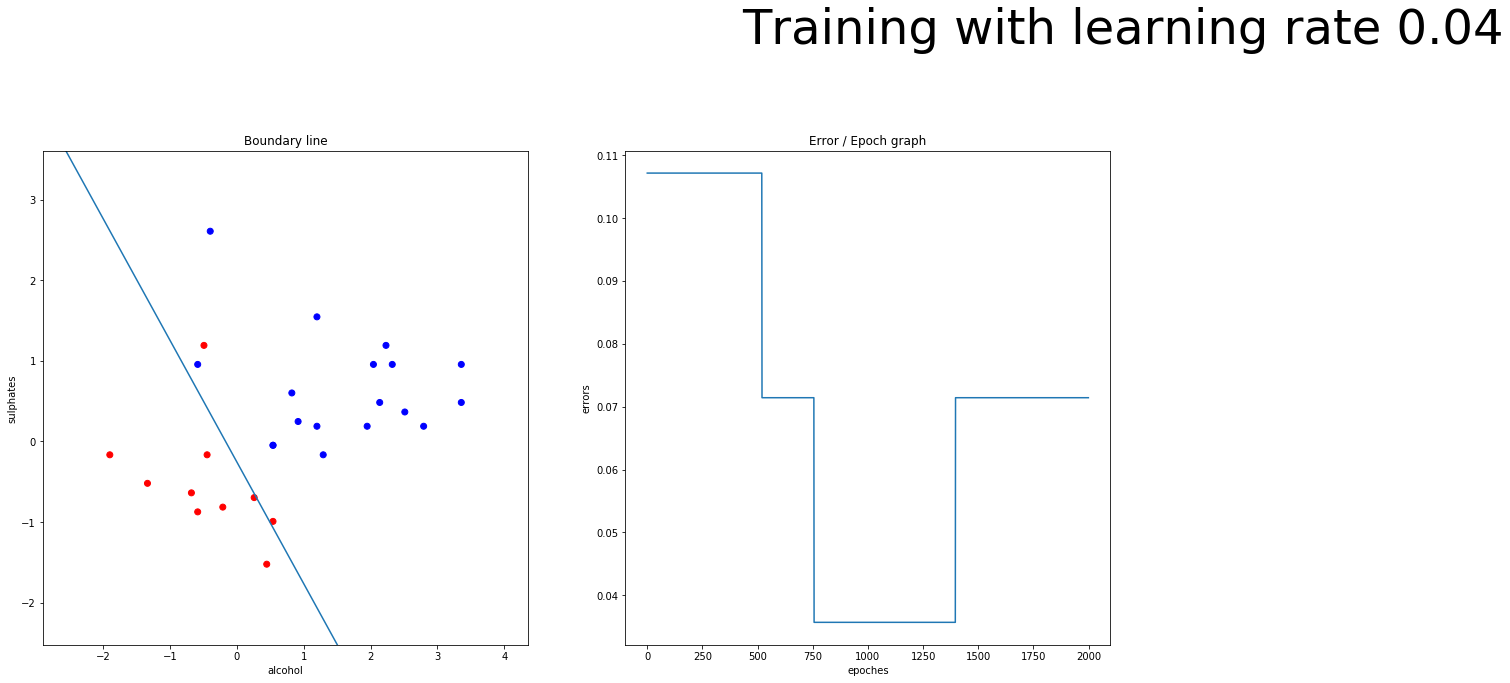

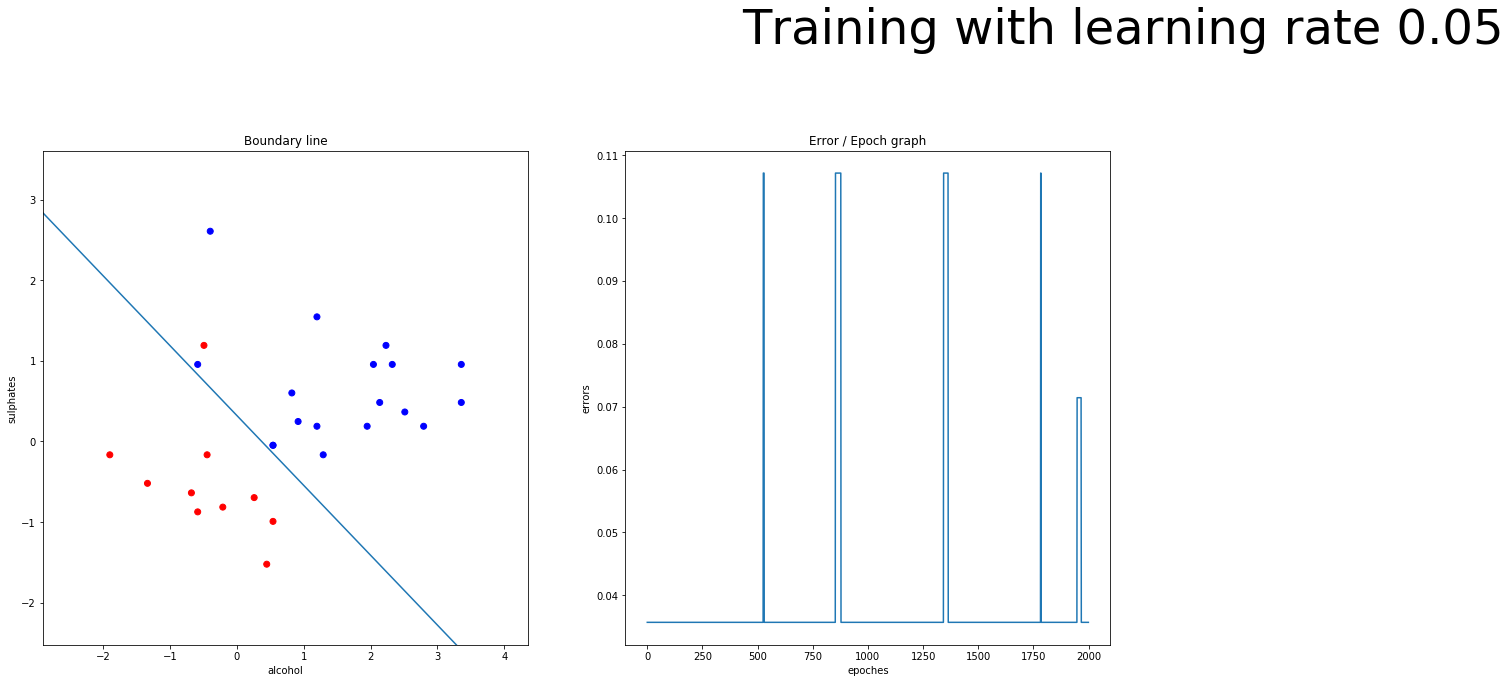

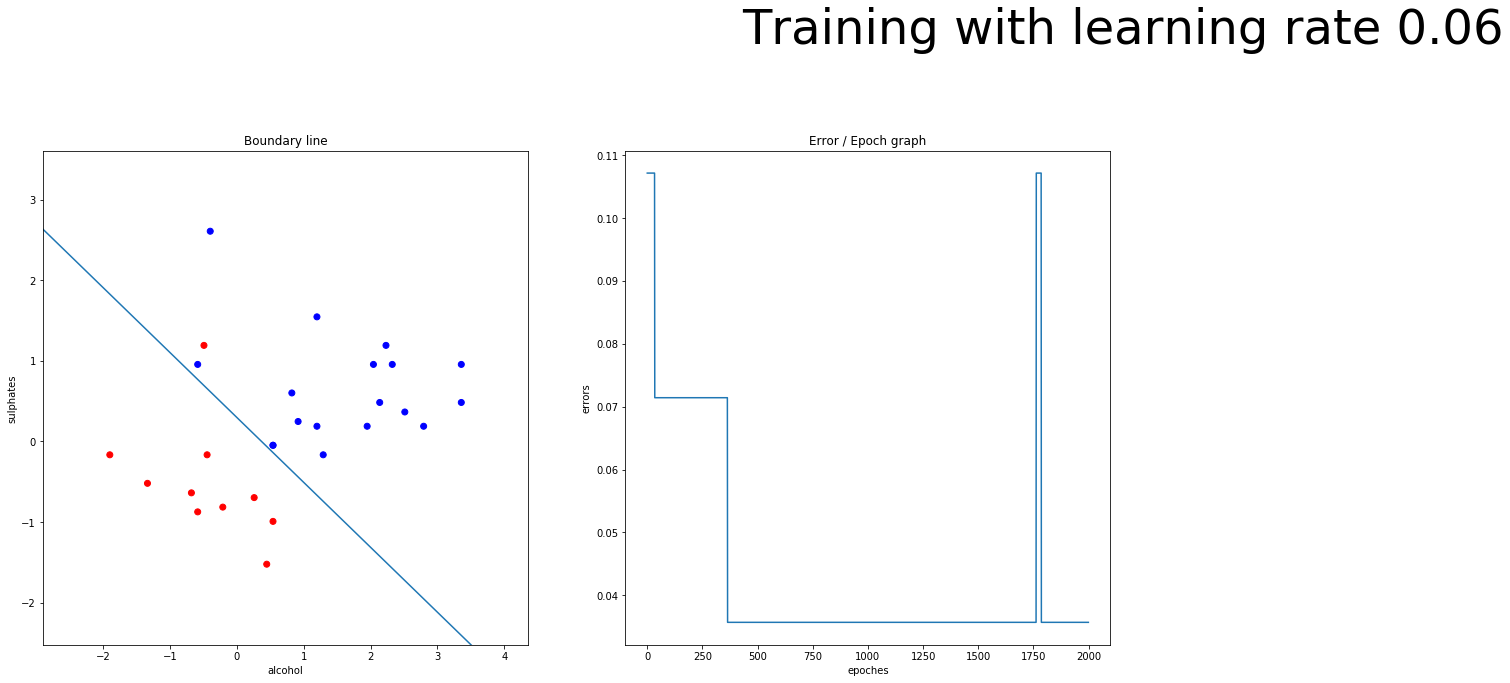

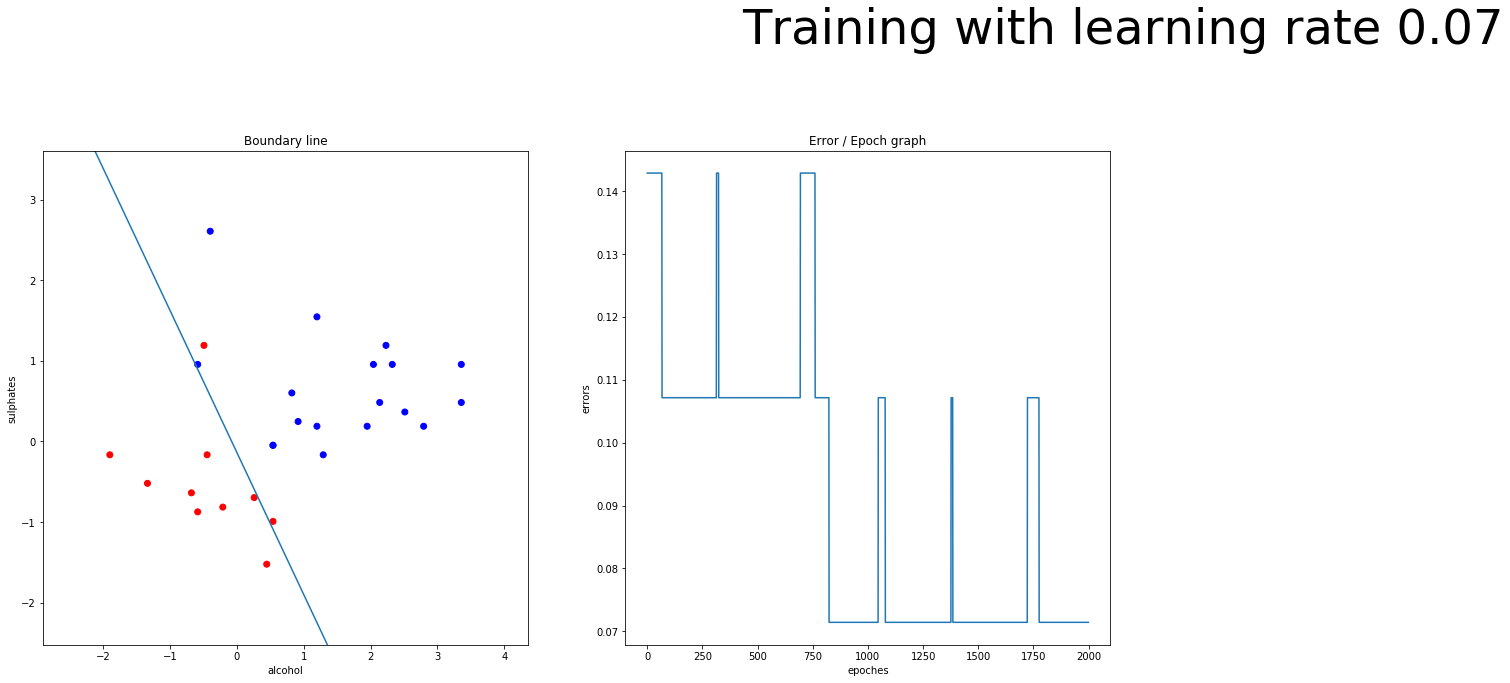

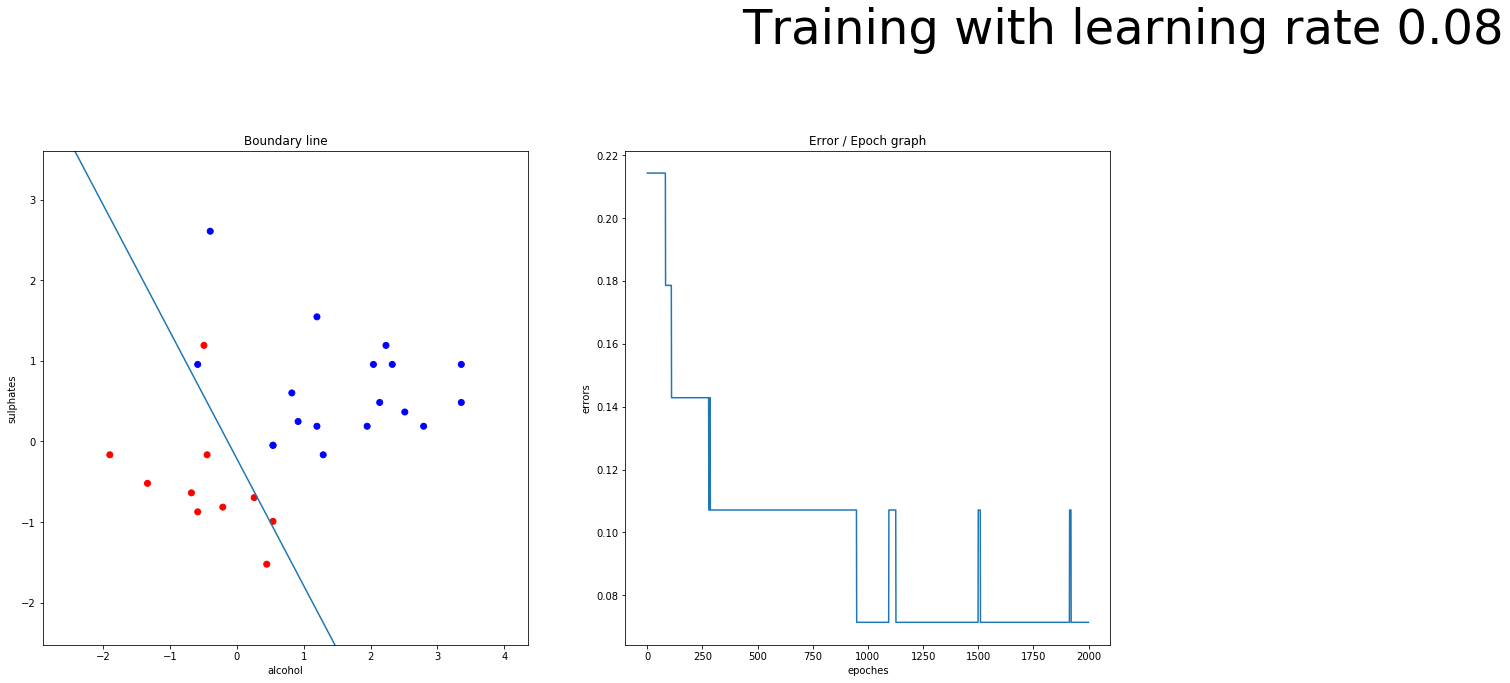

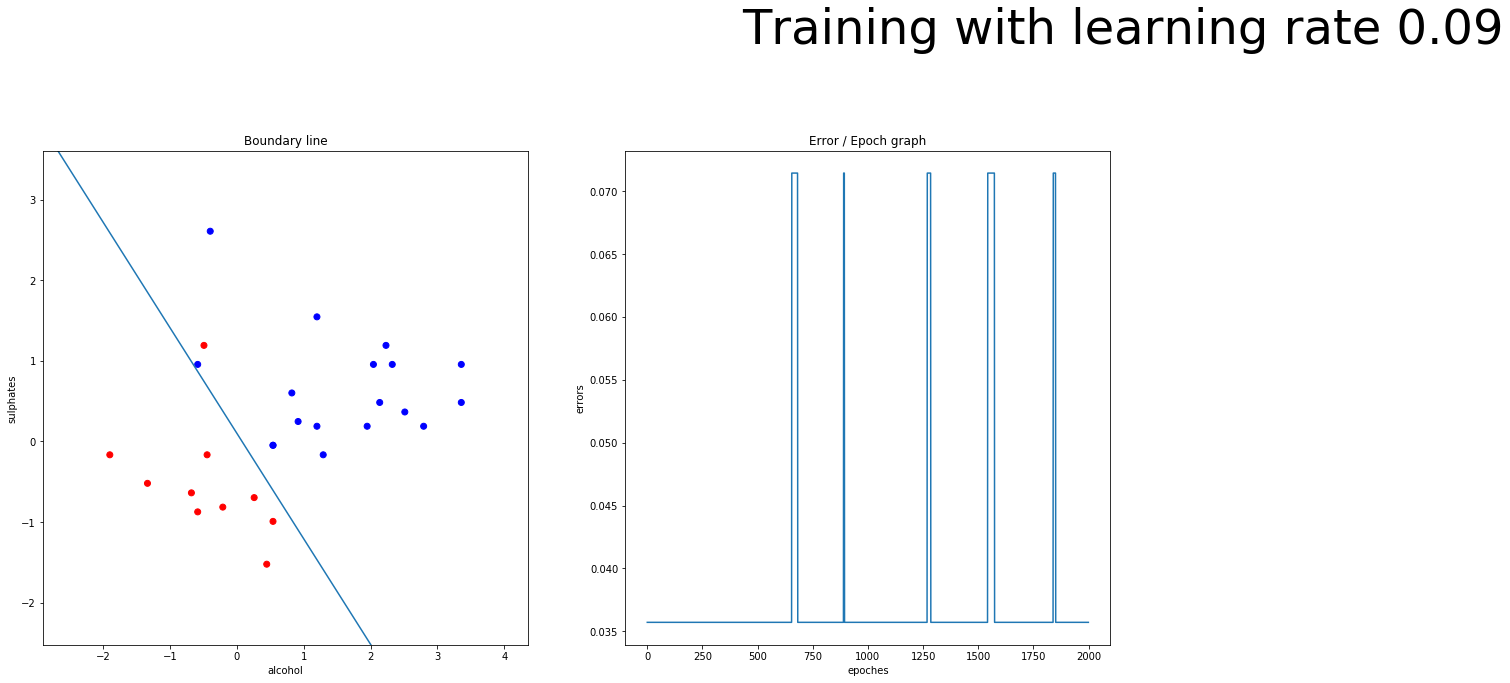

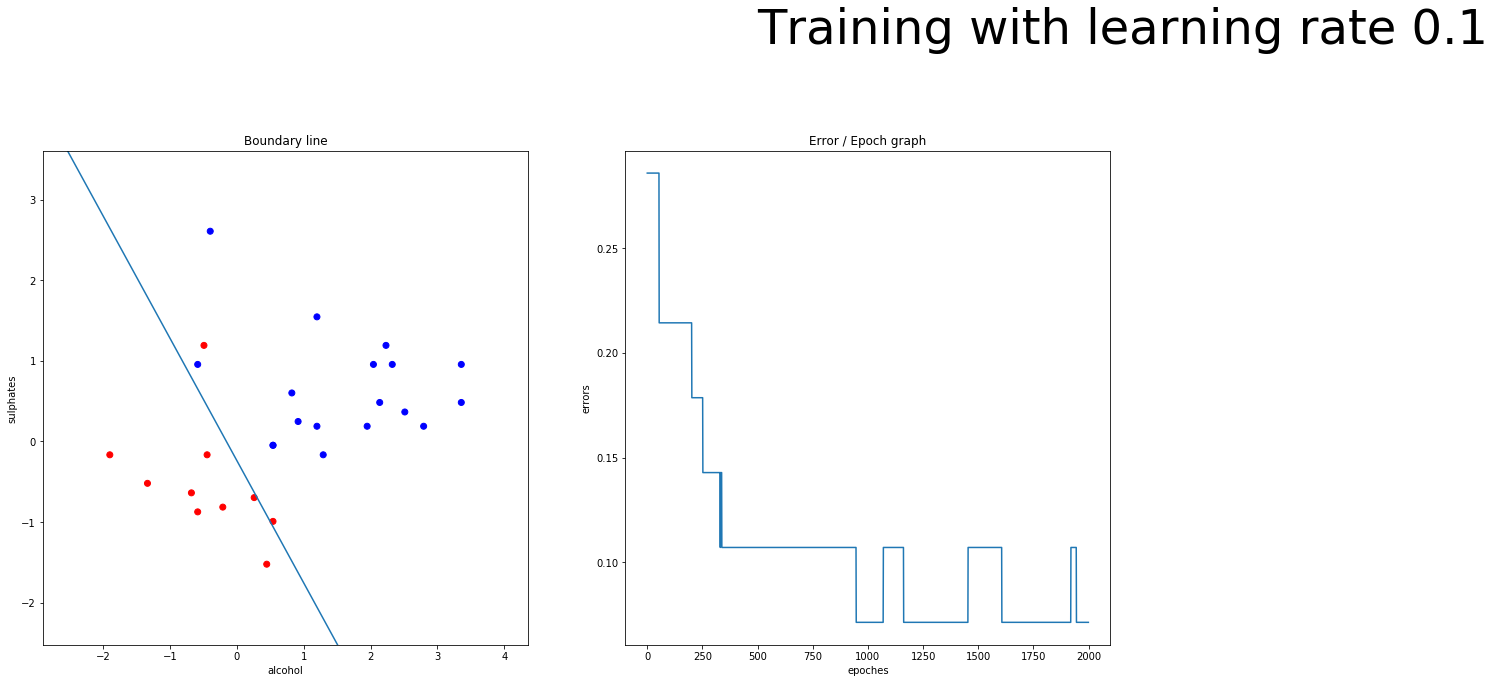

In [17]:
for l_r in [i * 0.01 for i in range(1, 11)]:
    performance = train_adaline(x, y, l_r, 2000)
    plot_performance(performance, df, 7, 4, "Training with learning rate {}".format(l_r), ['w0','alcohol', 'sulphates'])

Learning rate 0.1 tend to show least amount of errors

### V.4 Advanced wine sampling and resampling

### a) Holdout method

In [18]:
def holdout(df, frac = 0.8):
    train = df.sample(frac = frac, random_state = 200)
    test = df.drop(train.index)
    return (train, test)

### b) k-fold cross-validation

In [19]:
def k_fold(df, k = 10, shuffle = False):
    df = df.sample(frac=1).reset_index(drop = True) if shuffle else df
    n = len(df)
    res = list()
    for i in range(1, k + 1):
        test = df[n * (i - 1) // k : n * i // k]
        p1 = df[n * i // k :]
        p2 = df[:n * (i - 1) // k]
        train = pd.concat([p1, p2])
        res.append((train, test))
    return res

### c) Train and assess

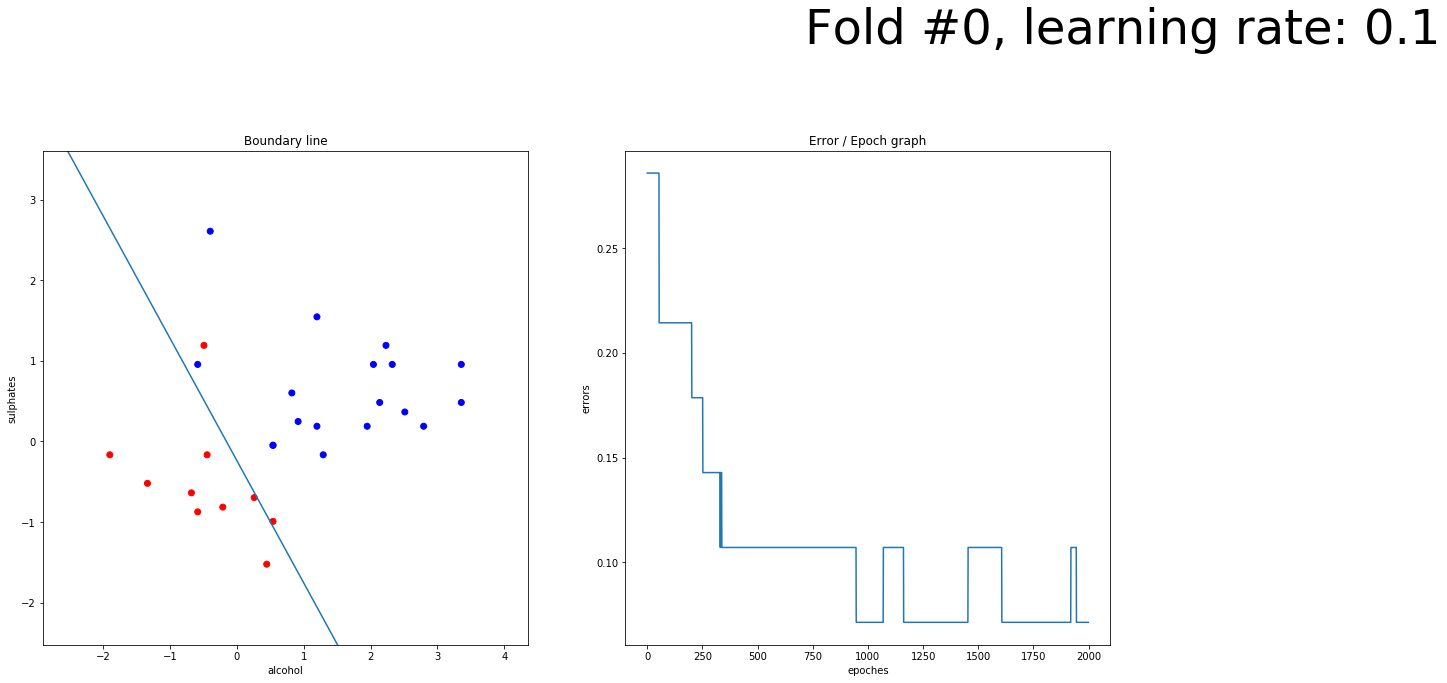

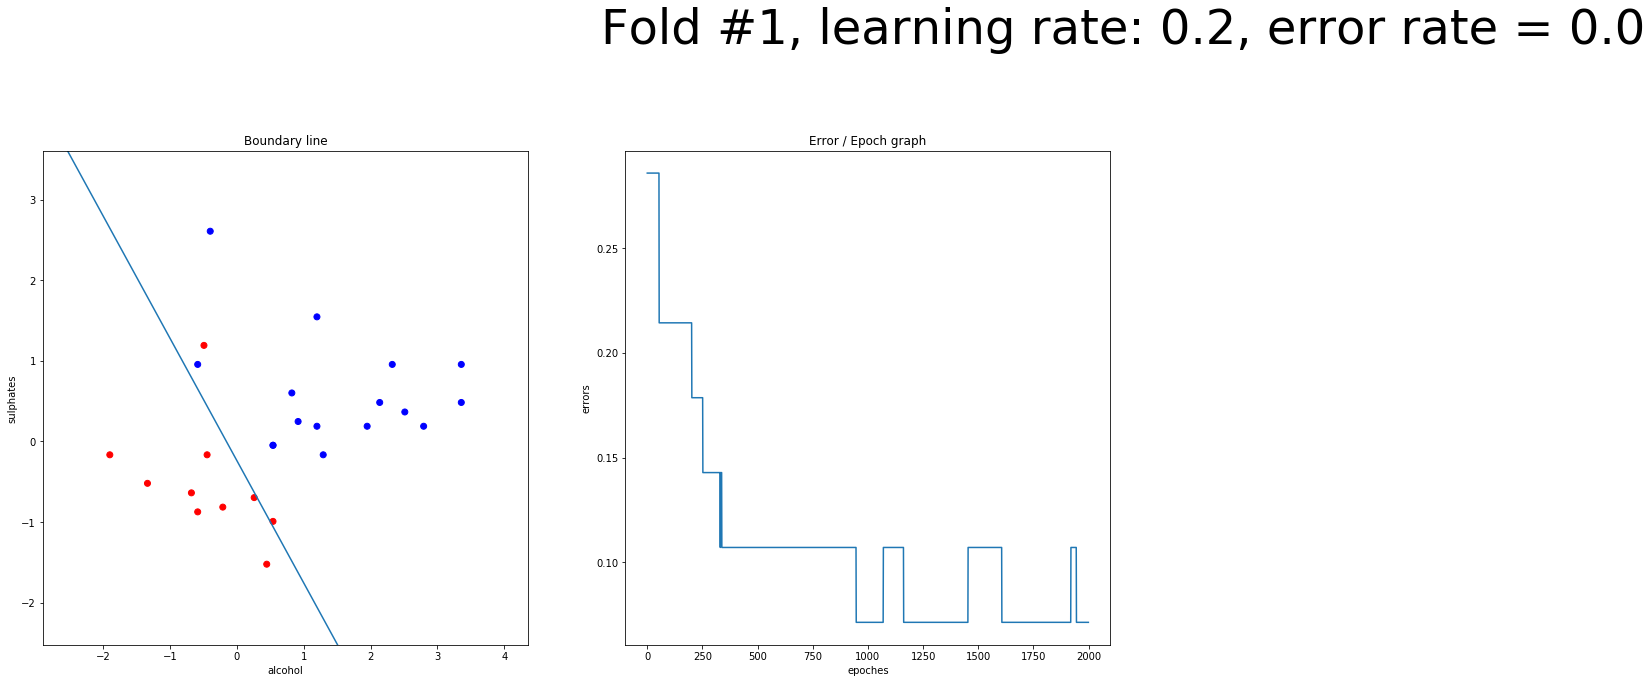

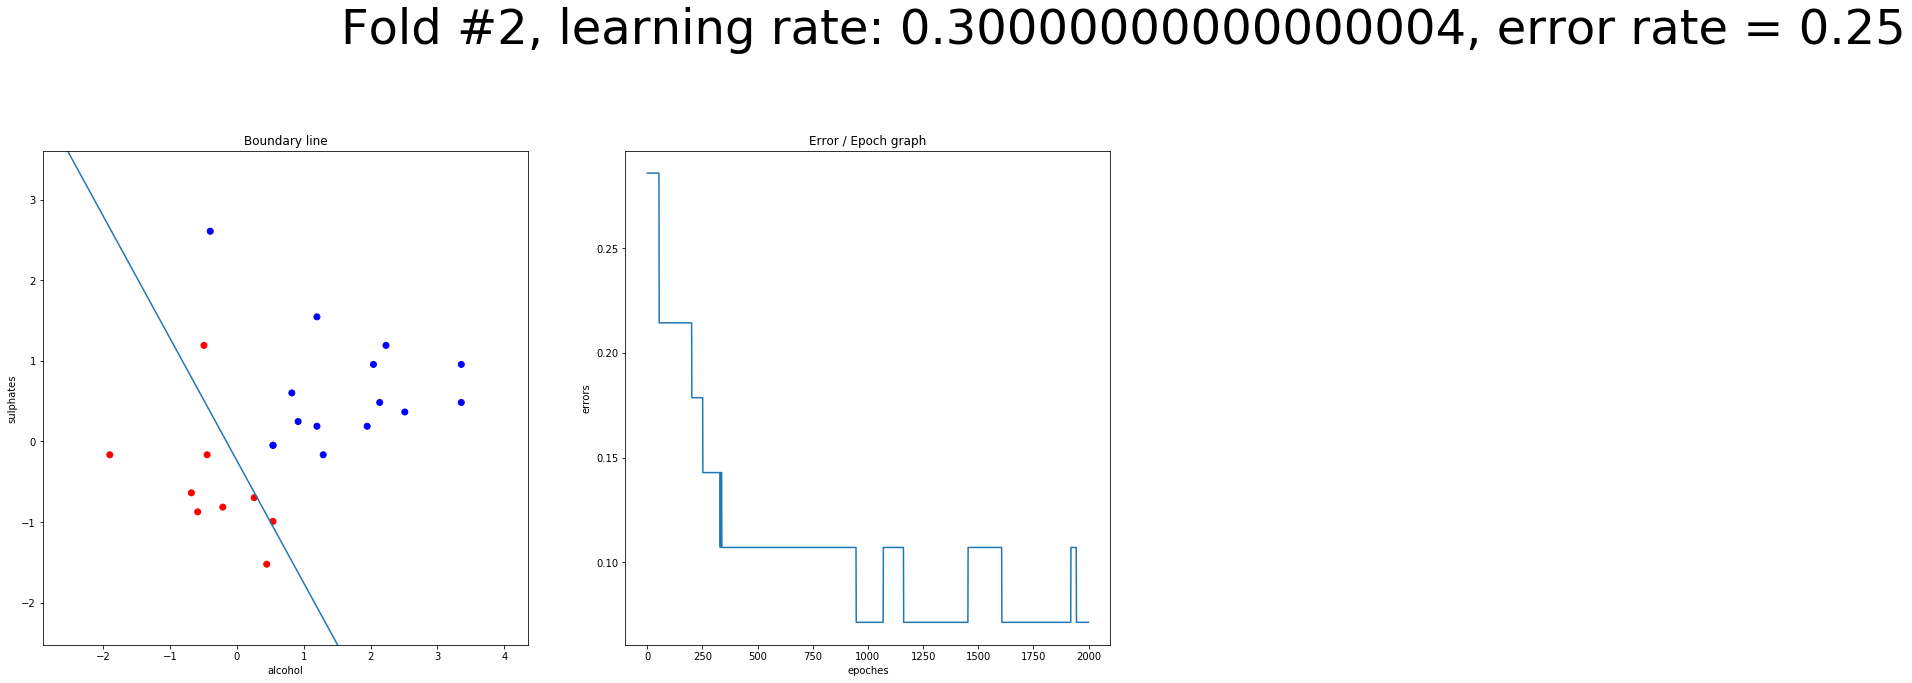

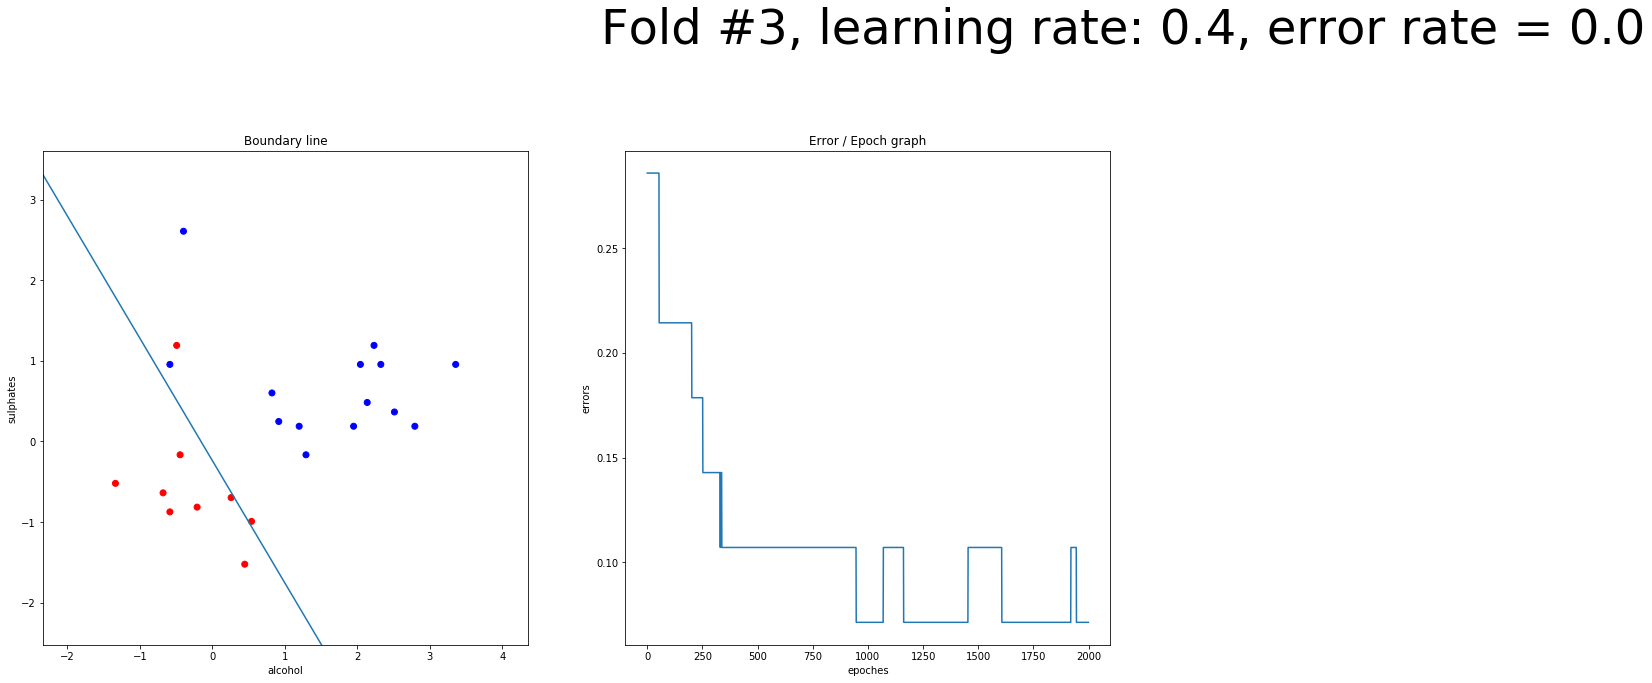

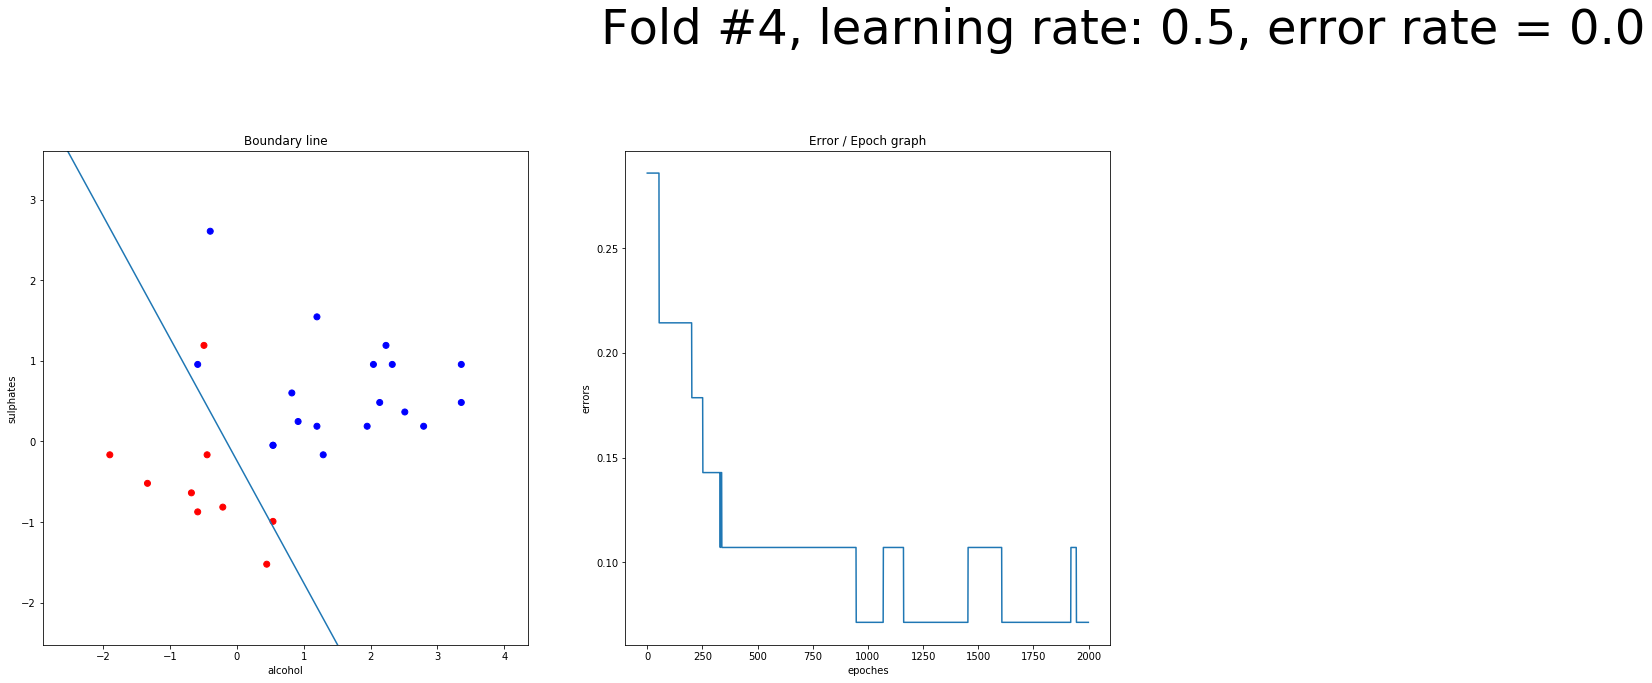

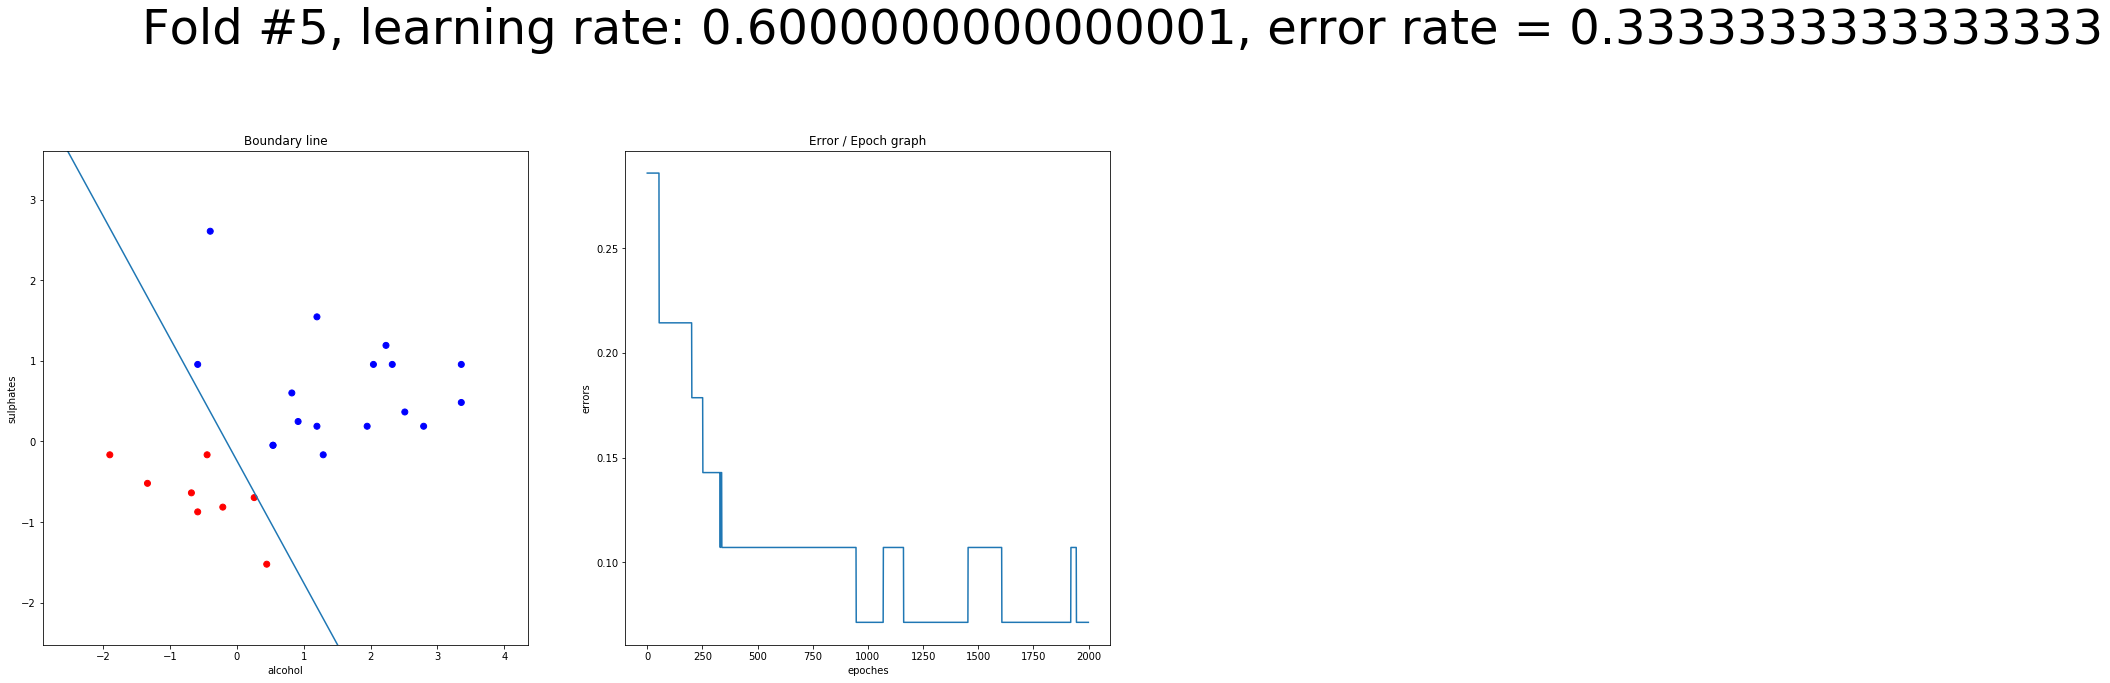

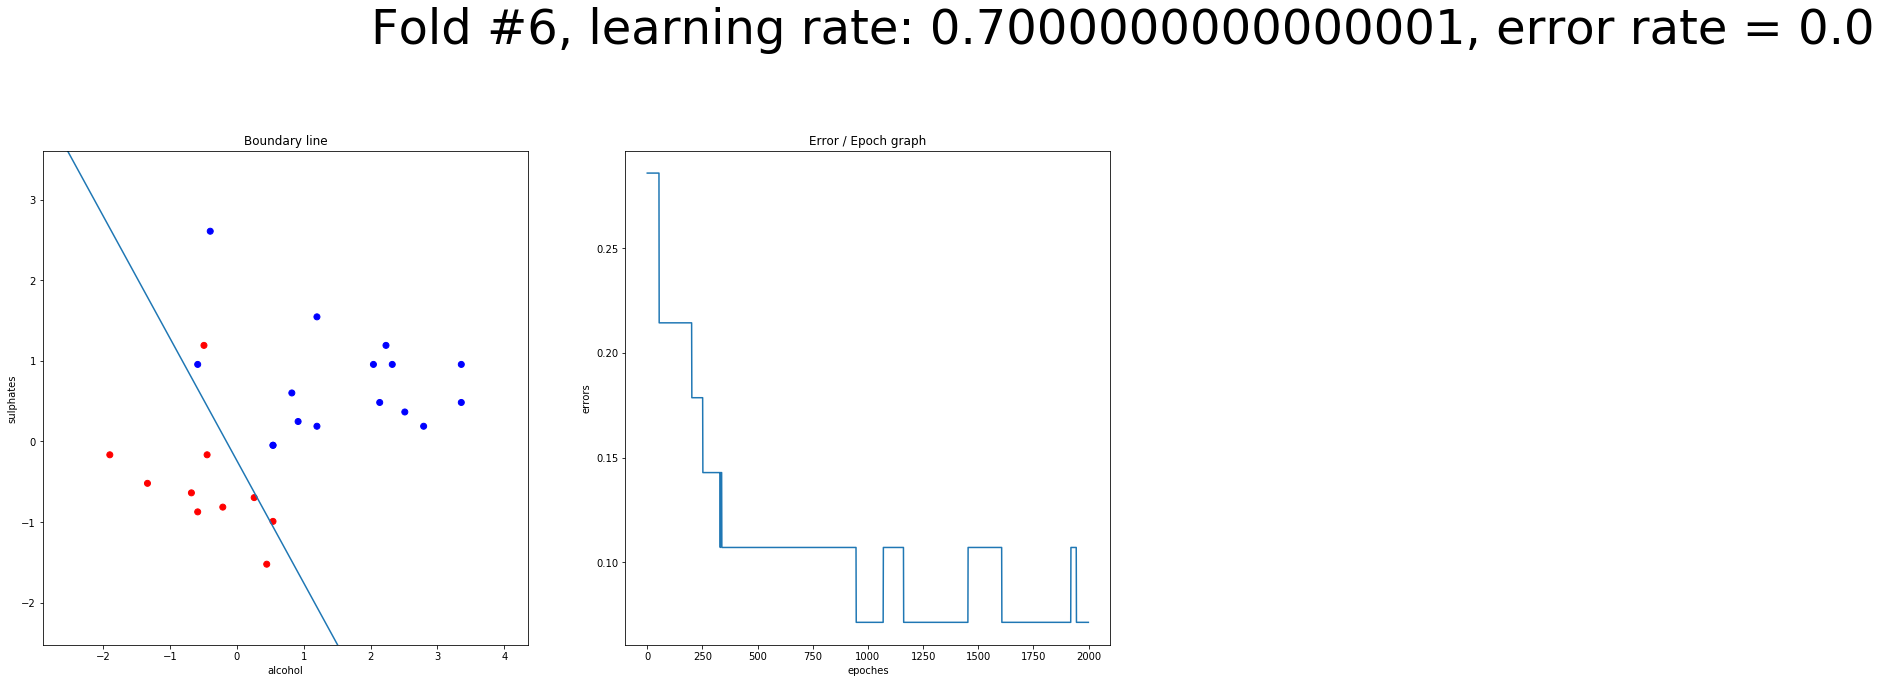

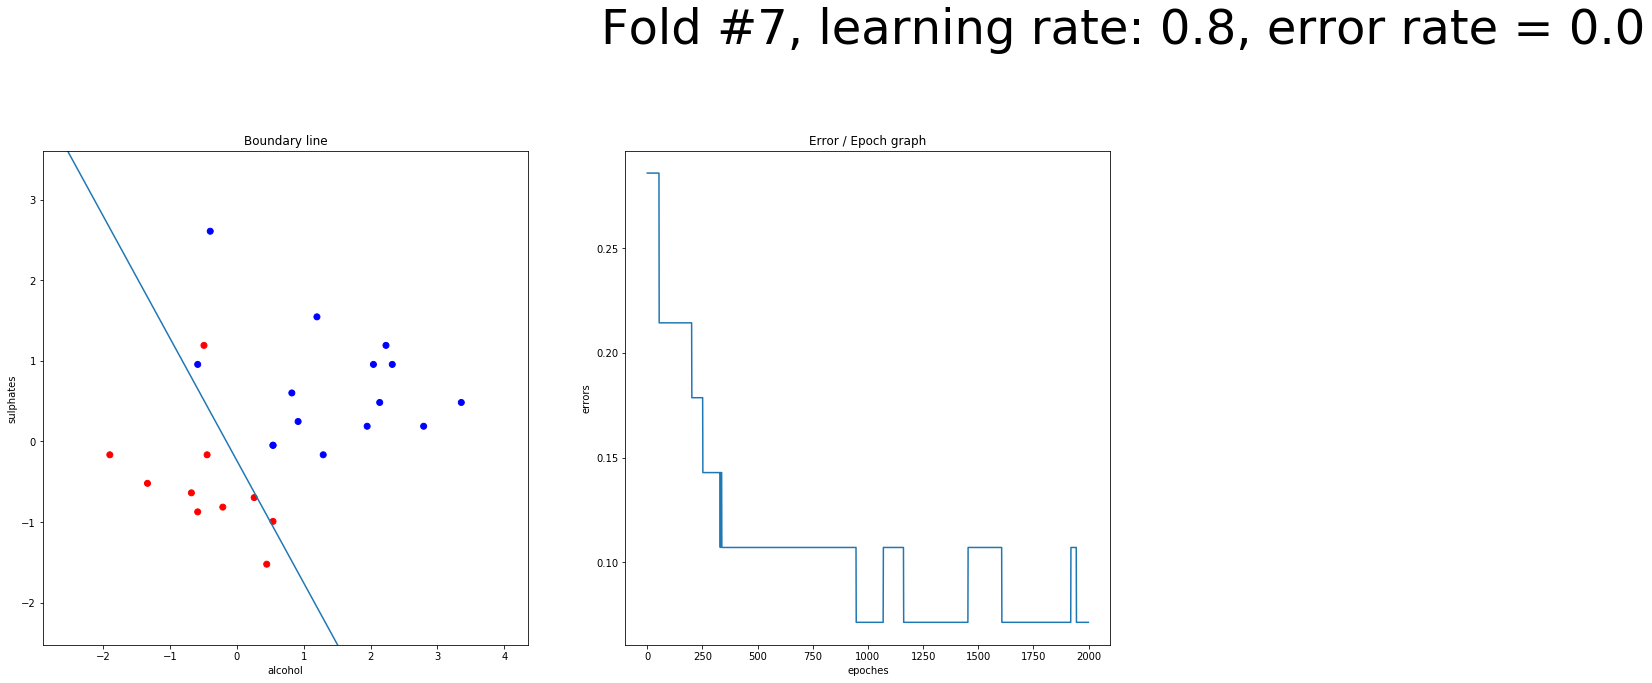

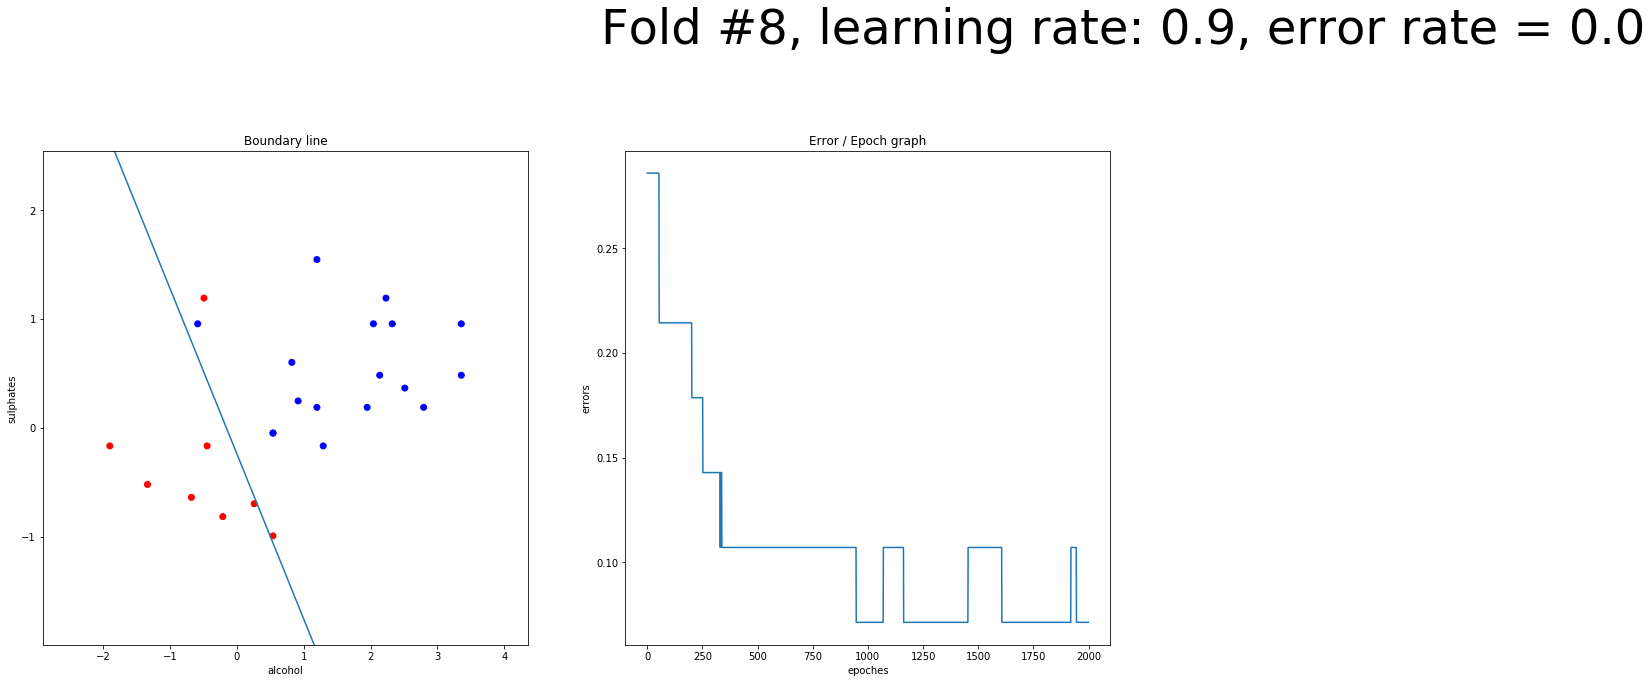

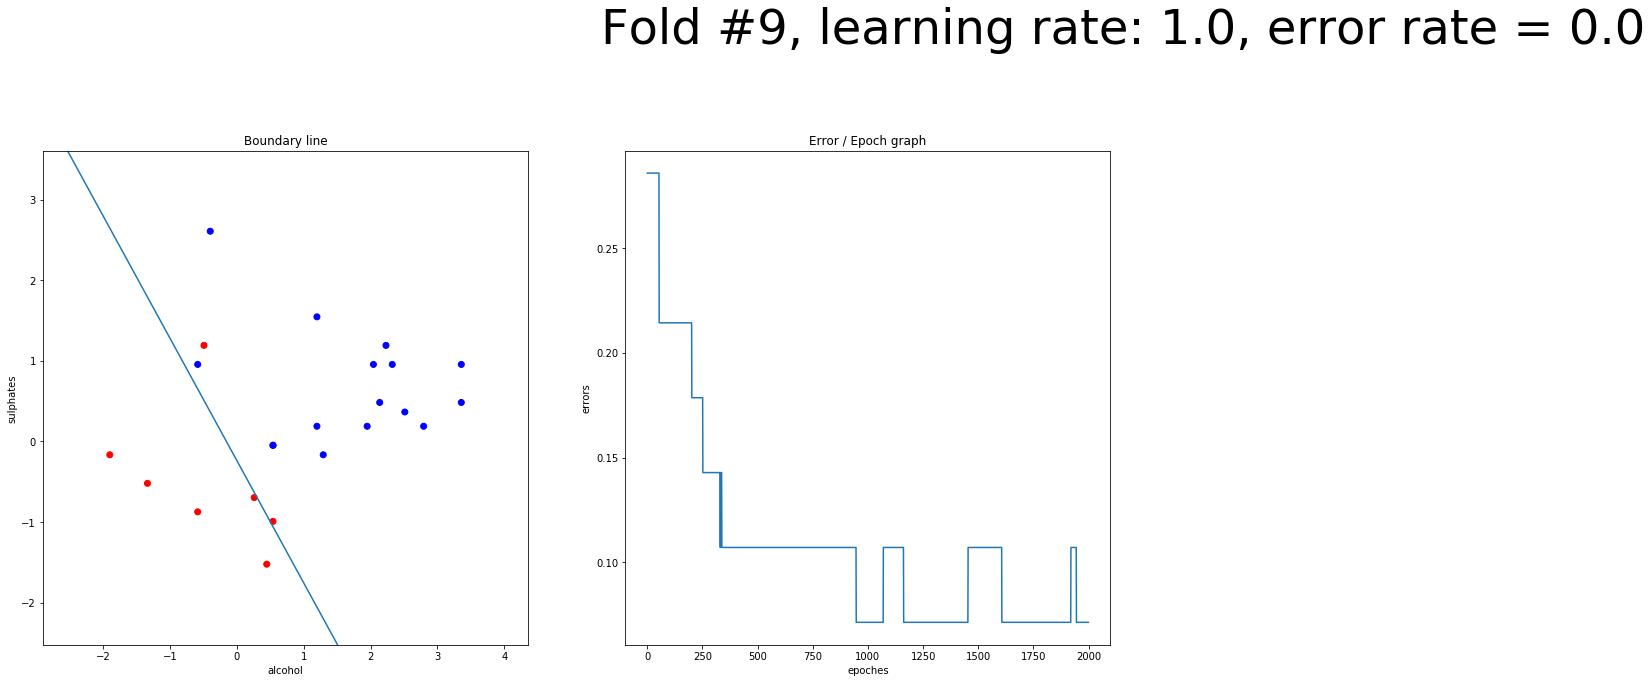

In [20]:
def train_and_assess(df):
    folds = k_fold(df)
    l_r = 1
    for i, fold in enumerate(folds):
        train_df = fold[0]
        test_df = fold[1]

        features = ['w0','alcohol', 'sulphates']
        x = train_df[train_df.result >= 0][features].values
        y = train_df[train_df.result >= 0]['result'].values
        x_test = test_df[test_df.result >= 0][features].values
        y_test = test_df[test_df.result >= 0]['result'].values

        w, errors = train_adaline(x, y, l_r * 0.1, 1000)
        cost = 0.0
        for index in range(len(x_test)):
            if adaline_predict(x_test[index], w[-1]) != y_test[index]:
                cost += 1

        title = "Fold #{}, learning rate: {}".format(i, l_r * 0.1)
        if (len(x_test) != 0):
            title = str(title) + ', error rate = ' + str(cost/len(x_test))
        plot_performance(performance, train_df, 7, 4, title, features)
        l_r += 1

train_and_assess(df)

### V.5 Adventures in the Nth dimension

#### a) & b) Training on 5 features and plotting its boundary

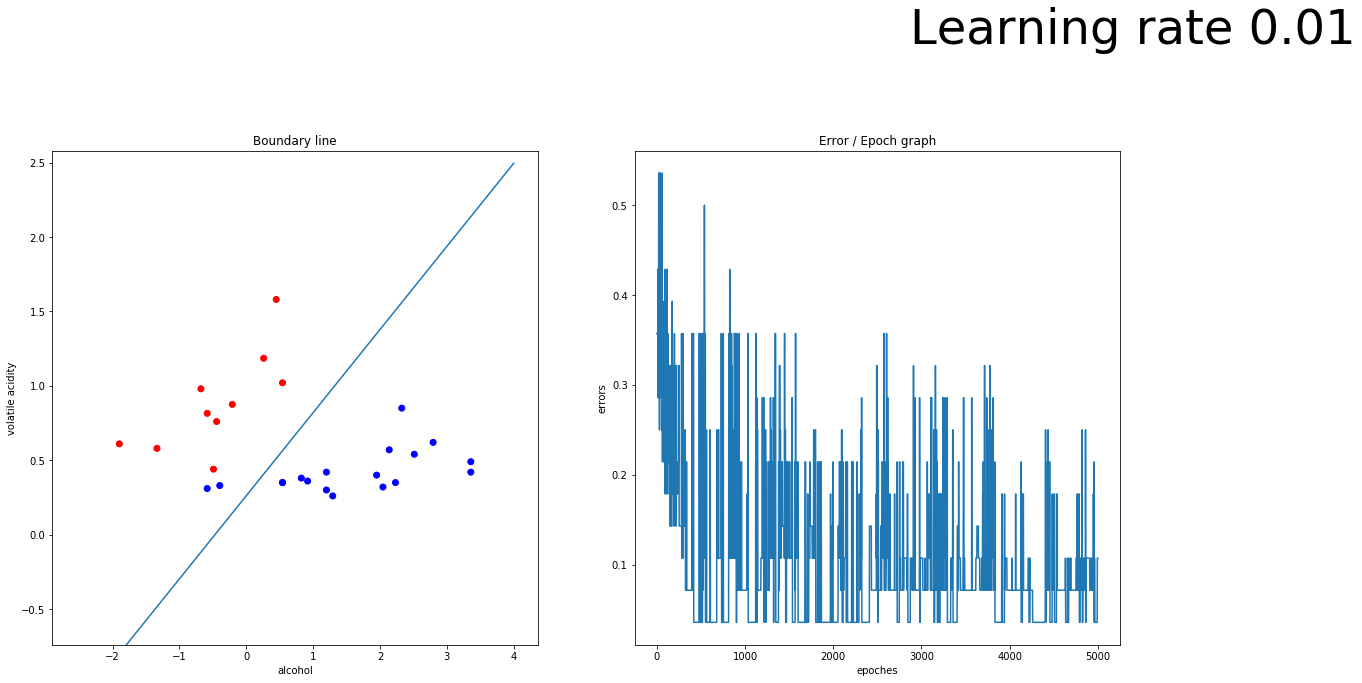

In [21]:
df['result'] = df.apply(lambda row: make_threshold(row['quality'], 7, 4), axis = 1)
features = ['w0', 'alcohol', 'volatile acidity', 'fixed acidity','pH']
x = df[df.result >= 0][features].values
y = df[df.result >= 0]['result'].values
performance = train_weights(x, y, 0.1, 5000)
plot_performance(performance, df, 7, 4, "Learning rate 0.01", features)

### V.6 Marvin’s rebuttal

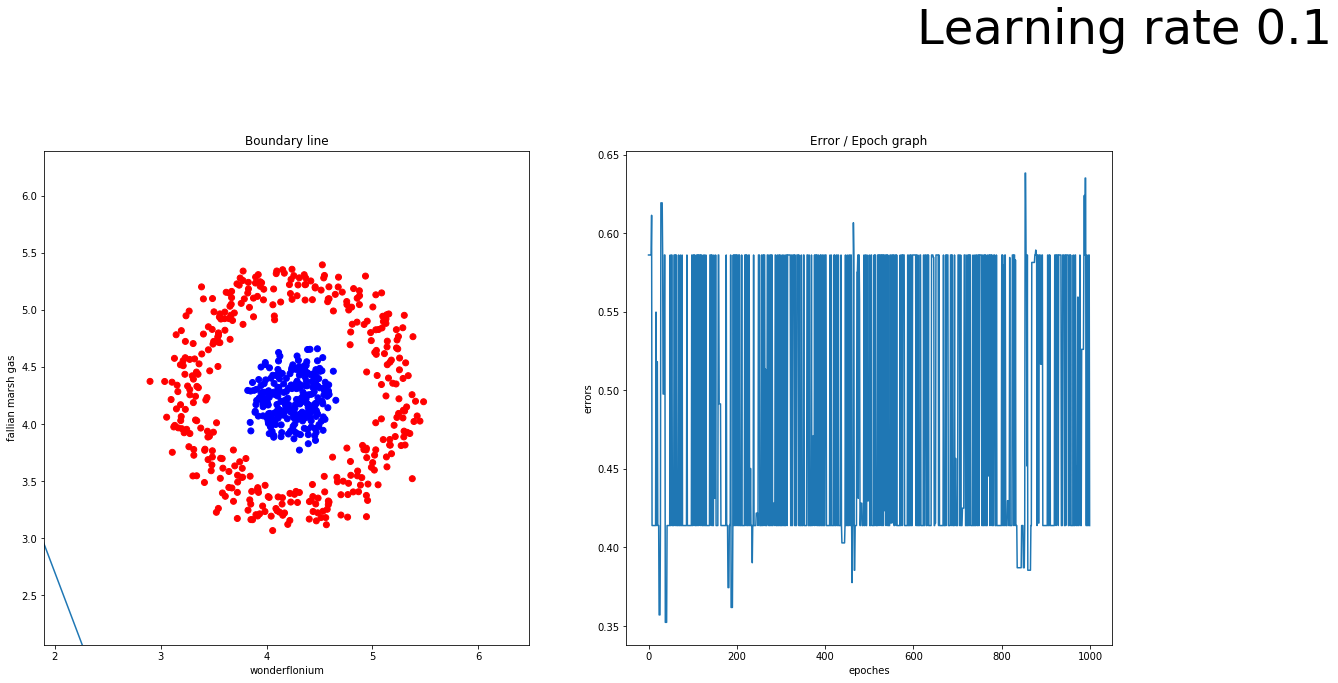

In [22]:
pan = pd.read_csv('Pan Galactic Gargle Blaster.csv', sep = ';')
pan['result'] = pan.apply(lambda row: make_threshold(row['quality'], 7, 4), axis = 1)
pan['w0'] = 1
pan_features = ['w0', 'wonderflonium', 'fallian marsh gas']
x = pan[pan.result >= 0][pan_features].values
y = pan[pan.result >= 0]['result'].values
performance = train_weights(x, y, 0.1, 1000)
plot_performance(performance, pan, 7, 4, "Learning rate 0.1", pan_features)

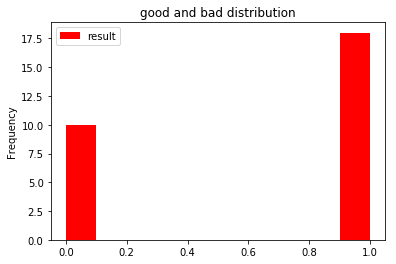

In [23]:
df.plot(kind = 'hist', y = 'result', color = 'red', title = 'good and bad distribution')

### VI.2 Do perceptrons dream of electric sheep?

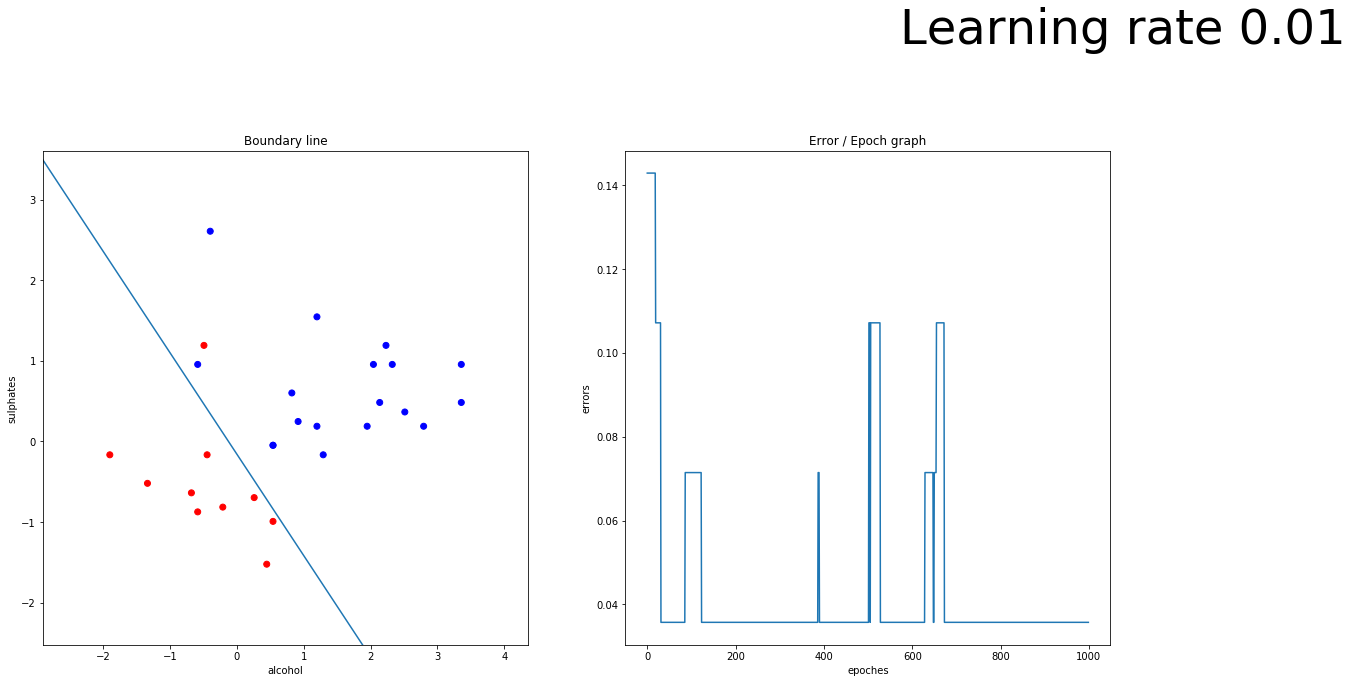

In [24]:
df['result'] = df.apply(lambda row: make_threshold(row['quality'], 7, 4), axis = 1)
df['w0'] = 1
x = df[df.result >= 0][['w0', 'alcohol', 'sulphates']].values
y = df[df.result >= 0]['result'].values
performance = train_weights(x, y, 0.1, 1000)
plot_performance(performance, df, 7, 4, "Learning rate 0.01", ['w0','alcohol', 'sulphates'])

In [25]:
from matplotlib import animation

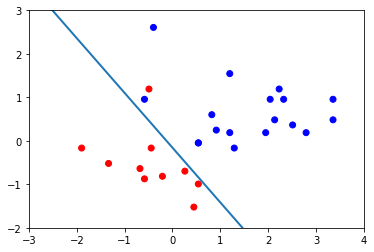

In [26]:
def animate_train(performance, features):
    fig = plt.figure()
    ax = plt.axes(xlim=(-3, 4), ylim=(-2, 3.0))
    x = df[df.result >= 0][features].values
    y = df[df.result >= 0]['result'].values
    x1 = [x1[1] for x1 in x]
    x2 = [x2[2] for x2 in x]
    colors = ListedColormap(['red', 'blue'])
    ax.scatter(x1, x2, c = y, cmap = colors)
    line, = ax.plot([], [], lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        w, errors = performance

        def func(x, w):
            slope = -(w[0]/w[2])/(w[0]/w[1])  
            intercept = -w[0]/w[2]
            y = (slope*x) + intercept
            return (y)

        x_line = [j for j in range(int(min(x1)) - 2, int(max(x1)) + 2)]
        y_line = [func(j, w[i]) for j in x_line]

        line.set_data(x_line, y_line)
        return line,

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=25, metadata=dict(artist='Me'), bitrate=1800)

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(performance[0]), interval=20, blit=True)
    anim.save('training.mp4', writer=writer)

animate_train(performance, ['w0','alcohol', 'sulphates'])

### VI.3 Dimensional traveler

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

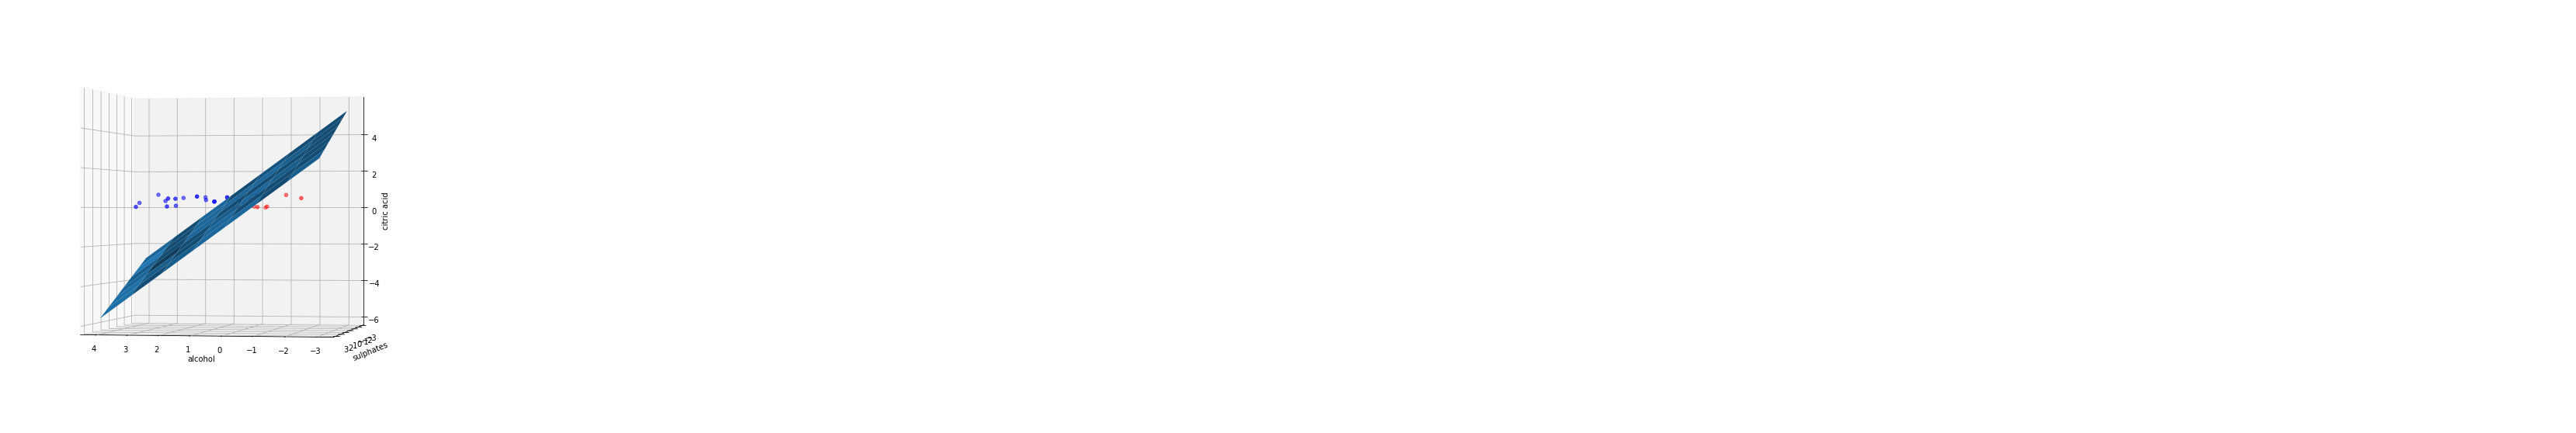

In [28]:
def plot_3d(performance, features):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d') # get current axis
    x = df[df.result >= 0][features[1]].values
    y = df[df.result >= 0][features[2]].values
    z = df[df.result >= 0][features[3]].values

    colors = ListedColormap(['red', 'blue'])
    surf = ax.scatter(x, y, z, c = df[df.result >= 0]['result'], cmap = colors)
    ax.set_xlabel(features[1])
    ax.set_ylabel(features[2])
    ax.set_zlabel(features[3])

    def func(x, y, w):
        return (-(w[0] + w[1] * x + w[2] * y) / w[3])

    x_line = [j for j in range(int(min(x)) - 2, int(max(x)) + 2)]
    y_line = [j for j in range(int(min(y)) - 2, int(max(y)) + 2)]
    x_line, y_line = np.meshgrid(x_line, y_line)
    z_line = func(x_line, y_line, performance[0][-1])
    ax.plot_surface(x_line, y_line, z_line)
    ax.view_init(0, 100)
    plt.show()

features = ['w0', 'alcohol', 'sulphates', 'citric acid']
x = df[df.result >= 0][features].values
y = df[df.result >= 0]['result'].values
performance = train_weights(x, y, 0.1, 1000)
plot_3d(performance, features)

### VI.1 Gotta go fast!

In [29]:
%load_ext cython

In [30]:
%%cython

from libc.stdlib cimport malloc, free, rand, srand, RAND_MAX
from cpython cimport array
import array

# Activation function (perceptron)
cdef int cpredict(object x, object w):
    cdef float activation = 0
    for i in range(len(x)):
        activation += w[i] * x[i]
    return 1 if activation >= 0 else 0

cdef cdiff(object a, object b):
    cdef array.array c = array.array('f', a)
    for i in range(len(a)):
        c[i] -= b[i]
    return (c)

cdef float cms_error(object x, object y, object w):
    cdef float sum_err = 0
    for i in range(len(y)):
        sum_err += (cpredict(x[i], w) - y[i])**2
    return sum_err/len(y)

cdef cgrad_step(object x, object y, object w, int i, float l_rate):
    cdef array.array grad = array.array('f', w)
    for j in range(len(w)):
        grad[j] = x[i][j] * (cpredict(x[i], w) - y[i])
    for j in range(len(w)):
        grad[j] *= 2 * l_rate / len(x[0])
    return grad


## TRAIN function
cpdef ctrain_weights(object x, object y, float l_rate, int n_epochs):
    cdef array.array w = array.array('f', x[0])
    for i in range(len(w)):
        w[i] = rand()/RAND_MAX
    cdef array.array errors = array.array('f', range(n_epochs))
    for index in range(n_epochs):
        random_idx = int(rand()/(RAND_MAX) *(len(x) - 1))
        w = cdiff(w, cgrad_step(x, y, w, random_idx, l_rate))
        errors[index] = cms_error(x, y, w)
    return [w, errors]

# ################################## Adaline #######################################

cpdef float cadaline_input(x, w):
    cdef float res = 0
    for i in range(len(x)):
        res += x[i] * w[i]
    return (res)

cpdef int cadaline_predict(x, w):
    return 0 if cadaline_input(x, w) < 0.0 else 1

cpdef cgrad_step_ada(x, y, w, i, l_rate):
    cdef array.array grad = array.array('f', w)
    for j in range(len(x[0])):
        if y[i] == cadaline_predict(x[i], w):
            grad[j] = 0
        else:
            grad[j] = x[i][j] * (cadaline_input(x[i], w)/len(x[i]) - y[i])
    for j in range(len(x[0])):
        grad[j] *= 2 * l_rate / len(x[0])
    return grad

cpdef ctrain_adaline(x, y, l_rate, n_epochs):
    cdef array.array w = array.array('f', x[0])
    for i in range(len(w)):
        w[i] = rand()/RAND_MAX
    cdef array.array errors = array.array('f', range(n_epochs))
    for index in range(n_epochs):
        random_idx = int(rand()/(RAND_MAX) *(len(x) - 1))
        w = cdiff(w, cgrad_step_ada(x, y, w, random_idx, l_rate))
        errors[index] = cms_error(x, y, w)
    return [w, errors]

In [31]:
def cplot_performance(performance, wine_data, good_thresh, bad_thresh, title, features, epoch = -1, save_plot = False):
    wine_data['result'] = wine_data.apply(lambda row: make_threshold(row['quality'], good_thresh, bad_thresh), axis = 1)
    x = wine_data[wine_data.result >= 0][features].values
    y = wine_data[wine_data.result >= 0]['result'].values
    w, errors = performance
    
    shape = [4, 2]
    f = plt.figure(figsize=(shape[0] * 10, shape[1] * 10))
    f.suptitle(title, fontsize=48)
    ax = plt.subplot(shape[1], shape[0], 1)
    ax.set_title('Boundary line')
    plt.xlabel(features[1])
    plt.ylabel(features[2])
    
    x1 = [x1[1] for x1 in x]
    x2 = [x2[2] for x2 in x]
    colors = ListedColormap(['red', 'blue'])
    plt.scatter(x1, x2, c = y, cmap = colors)
    
    def func(x, w):
        slope = -(w[0]/w[2])/(w[0]/w[1])  
        intercept = -w[0]/w[2]
        y = (slope*x) + intercept
        return (y)
    
    x_line = [i for i in range(int(min(x1)) - 2, int(max(x1)) + 2)]
    y_line = [func(i, w) for i in x_line]
    plt.plot(x_line, y_line)
    plt.axis([min(x1) - 1, max(x1) + 1, min(x2) - 1, max(x2) + 1])
    
    ax = plt.subplot(shape[1], shape[0], 2)
    ax.set_title('Error / Epoch graph')
    plt.xlabel('epoches')
    plt.ylabel('errors')
    plt.plot(range(len(errors)), errors)
    fig.savefig("plot_performance.png") if save_plot else None

### Cython ADALINE

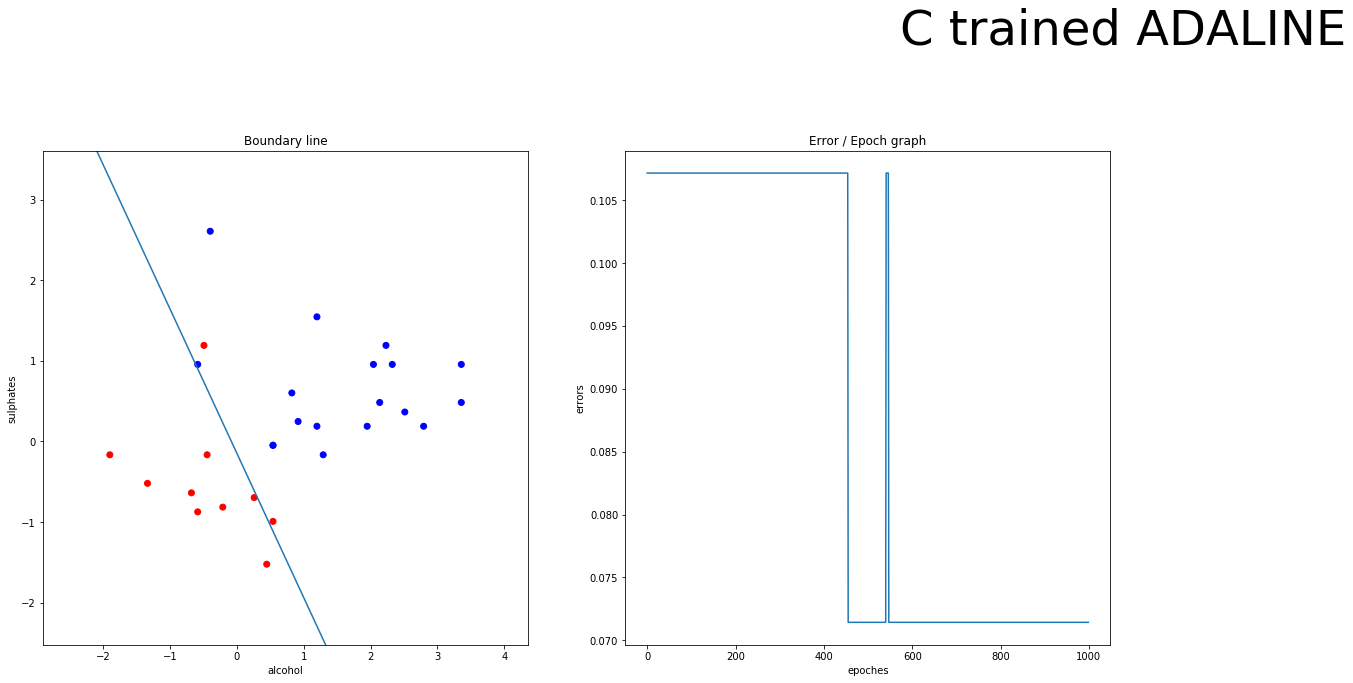

In [32]:
df['result'] = df.apply(lambda row: make_threshold(row['quality'], 7, 4), axis = 1)
df['w0'] = 1
x = df[df.result >= 0][['w0', 'alcohol', 'sulphates']].values
y = df[df.result >= 0]['result'].values
perf = ctrain_adaline(x, y, 0.1, 1000)
cplot_performance(perf, df, 7, 4, "C trained ADALINE", ['w0', 'alcohol', 'sulphates'])

### Cython Perceptron

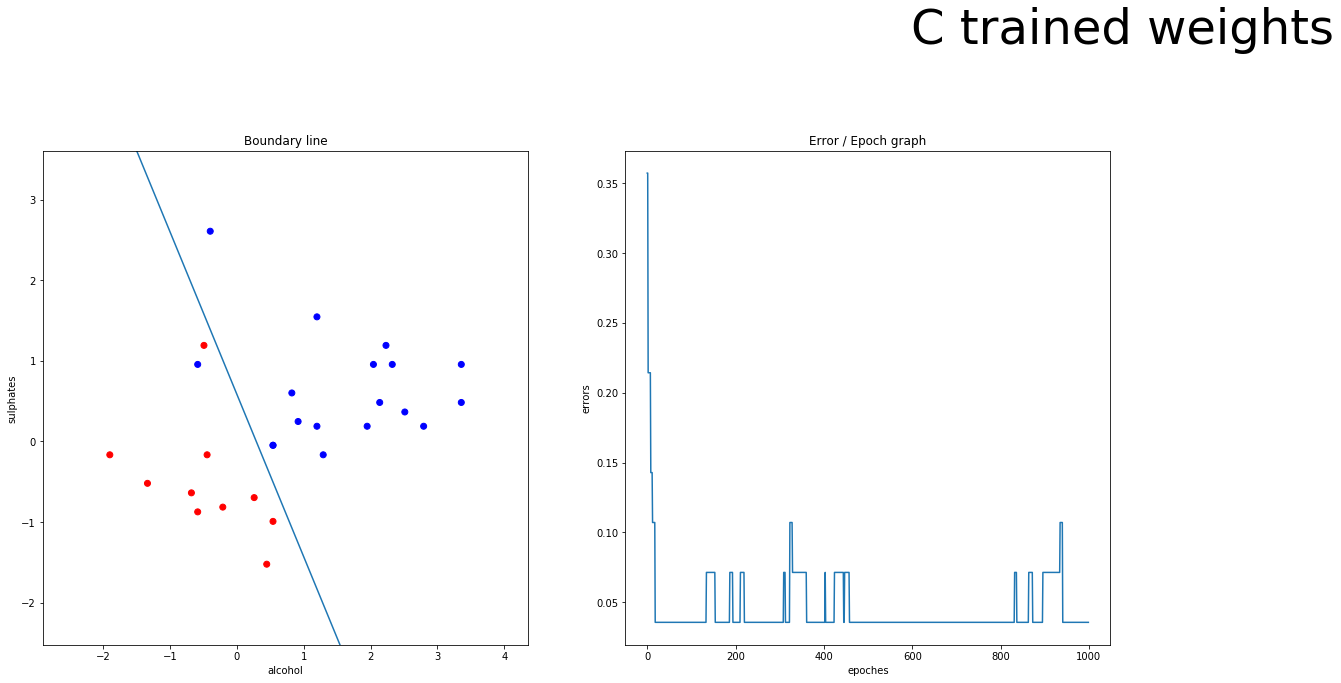

In [33]:
df['result'] = df.apply(lambda row: make_threshold(row['quality'], 7, 4), axis = 1)
df['w0'] = 1
x = df[df.result >= 0][['w0', 'alcohol', 'sulphates']].values
y = df[df.result >= 0]['result'].values
perf = ctrain_weights(x, y, 0.1, 1000)
cplot_performance(perf, df, 7, 4, "C trained weights", ['w0', 'alcohol', 'sulphates'])